# Projet Traitement et Données Large Échelle

Zoé MARQUIS & Charlotte KRUZIC

!! Attention : Notebook très long (environ 45 minutes d'exécution)

Cela s'explique par la nature du benchmark :

- Chaque opération (Create, Read, Update, Delete) est répétée 5 fois pour assurer la fiabilité des résultats.
- À chaque Update ou Delete (et même Select pour rester cohérent), il est nécessaire de drop la table et l’index, puis de les recréer.
- Nous avons testé sur différents volumes de données : faible, 8k, et 30k, pour observer les variations de performances.
- Nous avons évalué les performances avec 1, 2, et 5 réplicas.
- Enfin, les tests ont été réalisés avec et sans index.

## Exécution des scripts d'installation 

Nous avons initialement exploré la possibilité d'exécuter nos scripts sur Google Colab afin de faciliter l'exécution sans que vous ayez à configurer quoi que ce soit sur votre machine locale. Cependant, Colab présente certaines limitations, notamment l'incapacité de gérer plusieurs réplicas sets, car il ne permet de travailler qu'avec un seul environnement d'exécution.

Pour pouvoir simuler plusieurs réplicas sets dans notre projet, nous avons besoin de plusieurs nœuds, ce qui n'est pas possible sur Colab. Nous avons également essayé d'utiliser des solutions gratuites comme Datastax (ou une autre plateforme similaire), mais ces services ne permettaient pas de configurer correctement les réplicas sets, ce qui limitait la flexibilité nécessaire à notre projet.

En conséquence, nous avons opté pour une autre solution : créer des fichiers de configuration et utiliser un Jupyter Notebook. Cette approche permet de travailler de manière plus flexible tout en maintenant un contrôle total sur les paramètres des réplicas sets.

!! Une autre remarque importante : le projet a été testé avec Python 3.11, car Python 3.12 a introduit quelques incompatibilités qui ont causé des bugs. Il est donc recommandé d'utiliser Python 3.11 pour éviter ces problèmes. !!

!! Toutes les instructions se trouvent dans `install_cassandra_linux.md` !!

### Choix de la base de données : MySQL vs SQLite
Initialement, nous avons choisi MySQL pour ses fonctionnalités robustes et sa capacité à gérer de grandes bases de données. Cependant, son intégration à Google Colab a posé plusieurs problèmes :

- Installation et configuration du serveur complexes dans un environnement éphémère.
- Difficulté à maintenir un serveur actif sur Colab, entraînant des arrêts inattendus.
- Configuration complexe pour établir des connexions sécurisées à distance. 

Pour simplifier, nous avons opté pour SQLite, une solution mieux adaptée à nos besoins :

- Sans serveur : Pas de configuration complexe, tout fonctionne directement via des fichiers.
- Compatibilité native : Intégré à Python, fonctionne localement et sur le cloud.

SQLite s'est révélé être une solution efficace, ce qui nous a incités à le conserver lors de notre transition vers Jupyter Notebook.

# Comparaison de Performances entre Systèmes Relationnels et NoSQL : Étude de Cas avec le Catalogue Netflix

Dans ce projet, nous comparons les performances entre un système de base de données relationnel (SQLite) et un système NoSQL (Cassandra), en utilisant le **catalogue Netflix** comme jeu de données.   
Ce dataset, disponible en Open Data, offre une structure réaliste et adaptée pour explorer les différences entre ces deux approches de gestion de données.   
L'objectif principal est d'évaluer les performances des opérations d'insertion, de sélection, de mise à jour et de suppression, tout en explorant les particularités du système NoSQL choisi.

### Jeu de données

Le jeu de données utilisé contient des informations sur les films et séries disponibles sur Netflix, avec les attributs suivants : 
- `show_id` : Identifiant unique pour chaque émission ou film. 
- `type` 
- `title`
- `director` 
- `cast`
- `country`
- `date_added` 
- `release_year` 
- `rating` 
- `duration` 
- `listed_in` 
- `description`

### Schéma de données

```sql
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
```


---

## Fonctionnement de Cassandra
Apache Cassandra est un système NoSQL conçu pour gérer de grandes quantités de données de manière distribuée, garantissant haute disponibilité et tolérance aux pannes grâce à son modèle décentralisé et évolutif.

### Modèle de données de Cassandra :

Le modèle de données de Cassandra repose sur quelques concepts clés qui diffèrent des systèmes relationnels traditionnels.

- **Keyspace** :  
Un Keyspace dans Cassandra est l'équivalent d'une base de données dans les systèmes relationnels. Il sert à regrouper des tables (ou Column Families) et définit la stratégie de réplication des données. Par exemple, il spécifie le nombre de répliques à conserver pour chaque donnée afin d'assurer une haute disponibilité et une tolérance aux pannes. La réplication des données dans Cassandra suit des stratégies comme "SimpleStrategy" (réplication sur tous les nœuds) ou "NetworkTopologyStrategy" (réplication sur des nœuds répartis sur plusieurs centres de données). Dans ce projet, nous n'explorerons que la stratégie "SimpleStrategy".
- **Column Family** :  
Une Column Family dans Cassandra est équivalente à une table relationnelle, mais avec une flexibilité plus grande. Chaque Column Family contient plusieurs colonnes, et contrairement aux bases de données relationnelles, les colonnes n'ont pas besoin d'être définies à l'avance. Elles peuvent être ajoutées dynamiquement au fil du temps, ce qui permet d'évoluer facilement sans migrations complexes.
- **Key (Clé primaire)** :  
Chaque ligne dans une Column Family est identifiée par une clé unique. Cette clé est utilisée pour partitionner et localiser les données efficacement. Elle peut être composée d'un seul champ (clé primaire simple) ou de plusieurs champs (clé primaire composée).
- **Colonnes** :  
Les données dans Cassandra sont stockées sous forme de colonnes. Chaque colonne a trois composants essentiels :
    - Nom : Le nom de la colonne (par exemple, title, release_year).
    - Valeur : La donnée proprement dite (par exemple, "Inception", "2010").
    - Timestamp : Le timestamp associé à la colonne, qui permet de gérer les versions des données et de résoudre les conflits de réplication, ce qui est essentiel dans un système distribué. Il permet de savoir quelle version d'une colonne est la plus récente.  
Ces colonnes sont indépendantes les unes des autres. Cela signifie qu'elles peuvent être insérées, mises à jour ou supprimées sans impacter les autres colonnes dans la même ligne.
- **Super Colonnes** :  
Les Super Colonnes sont une structure plus avancée dans Cassandra. Elles permettent de regrouper plusieurs colonnes sous un même nom de "super colonne". Cela permet de créer des structures hiérarchiques ou imbriquées dans les données, où une super colonne peut contenir plusieurs colonnes. Ce mécanisme est utile pour des cas complexes, mais il est souvent moins utilisé au profit de modèles de données plus simples.

Source : 
- http://www-igm.univ-mlv.fr/~dr/XPOSE2010/Cassandra/modele.html

### Les différentes clefs 

- **Clef primaire** :  Identifie de manière unique chaque enregistrement dans la table. Elle est formée de :
    - Clé de partition : Obligatoire.
    - Clés de clustering : Optionnelles.

- **Clef de partition** : Détermine sur quel nœud du cluster les données seront stockées. C'est la première composante de la clé primaire.
Cassandra utilise un algorithme de hachage pour distribuer les partitions uniformément sur les nœuds.
Tous les enregistrements ayant la même clé de partition seront stockés sur le même nœud (dans une partition).

- **Clef de clustering** : Organise les données au sein d'une partition.
Fait partie de la clé primaire, mais intervient après la clé de partition.
Les données sont triées dans l'ordre croissant (par défaut) ou décroissant au sein de chaque partition.

- **Clé secondaire** : Utilisée pour rechercher des données via une colonne qui n'est ni une clé de partition ni une clé de clustering. Cassandra génère un index secondaire pour accélérer les recherches sur cette colonne. Cependant, les performances peuvent être dégradées si l'index est utilisé pour des requêtes impliquant un balayage de nombreuses partitions. Une clé secondaire est définie en créant un **index** sur la colonne souhaitée.

Source: 
- https://www.baeldung.com/cassandra-keys

### Architecture de Cassandra :

L'architecture de Cassandra est décentralisée et repose sur un modèle peer-to-peer, ce qui signifie qu'il n'y a pas de nœud maître ou de coordination centralisée. Tous les nœuds sont égaux et partagent le même rôle. Cela permet une grande scalabilité et une tolérance aux pannes.

- **Partitions et Réplication** : Cassandra répartit les données entre différents nœuds via un mécanisme de partitionnement basé sur un hash de la clé primaire. Chaque nœud du cluster stocke une portion des données, et des répliques de ces données peuvent être présentes sur plusieurs nœuds, selon la stratégie de réplication définie dans le Keyspace. Cela permet à Cassandra d'assurer une haute disponibilité, même en cas de panne d'un ou plusieurs nœuds.
- **Consistence et Quorum** : Cassandra suit un modèle de consistance configurable, permettant de choisir entre des garanties de consistance fortes ou une consistance plus faible en fonction des besoins. Cela se configure via les paramètres Read Consistency Level et Write Consistency Level. Par exemple, un niveau de consistance QUORUM signifie qu'une opération de lecture ou d'écriture devra être validée par la majorité des répliques d'une donnée avant de réussir.

Source:
- https://www.geeksforgeeks.org/quorum-consistency-in-cassandra/

### Requêtes et Modèle de Consistance :

Les requêtes dans Cassandra utilisent le Cassandra Query Language (CQL), qui ressemble à SQL mais avec des différences significatives adaptées aux particularités du modèle NoSQL.

- **Clé primaire et partitions** : Dans Cassandra, la clé primaire détermine comment les données sont partitionnées et distribuées à travers les nœuds du cluster comme expliqué plus haut. Il est essentiel de bien concevoir cette clé pour assurer des performances optimales.
- **Sélection et filtrage** : Cassandra fonctionne très bien pour les requêtes basées sur la clé primaire. Les requêtes qui filtrent sur d'autres colonnes nécessitent l'utilisation d'index secondaires ou d'une modélisation spécifique des données pour garantir de bonnes performances. Filtrer sur une colonne sans index lève l'erreur ALLOW FILTERING, ce qui signifie que la requête pourrait être très coûteuse en termes de performance.

- 

### Avantages et Inconvénients de Cassandra :

#### Avantages :
- **Haute scalabilité horizontale** :
    - Possibilité d'ajouter facilement des nœuds pour s'adapter à une augmentation soudaine de la demande
    - Architecture scalable de façon linéaire permettant de déployer des clusters "multi-node"
- **Résilience et tolérance aux pannes**
    - Réplication des données sur plusieurs nœuds pour garantir une haute disponibilité
    Absence de point unique de défaillance
    - Capacité à continuer à fonctionner même en cas de panne d'un ou plusieurs nœuds
- **Flexibilité du modèle de données**
    - Prise en charge des données structurées, semi-structurées et non structurées
    - Possibilité d'ajouter de nouvelles colonnes sans affecter les données existantes
- **Performances élevées**
    - Impressionnante vitesse d'écriture de données
    - Capacité à traiter de vastes quantités de données dispersées entre de multiples serveurs
#### Inconvénients :
- L'un des principaux inconvénients de Cassandra réside dans la gestion des requêtes sur des colonnes non incluses dans la clé primaire, même lorsqu'un index est présent. Cela peut entraîner des problèmes de performances et nécessiter l'utilisation de la clause `ALLOW FILTERING`, qui est généralement déconseillée. 
Les index secondaires ne contiennent pas la clé de partition, ce qui oblige Cassandra à rechercher les données sur tous les nœuds du cluster. Cela peut être coûteux en termes de performances, surtout sur de grands clusters.
La clause `ALLOW FILTERING` est nécessaire lorsque Cassandra ne peut pas garantir une exécution efficace de la requête. Cela se produit souvent pour des requêtes impliquant des comparaisons (comme >, <) ou plusieurs colonnes filtrées sans clé de partition précise. 

Initialement, nous avons effectué les comparaisons pour les opérations SELECT, UPDATE et DELETE avec une condition sur `release_year > 2000` (toujours la même requête pour garantir la cohérence). Cependant, cette approche nécessitait l’utilisation de `ALLOW FILTERING`, ce qui empêchait de constater une réelle différence entre les cas avec ou sans index. Nous avons donc modifié nos tests en utilisant `release_year = 2000`, ce qui a permis d’observer des variations plus significatives.

Sources : 
- https://www.lebigdata.fr/apache-cassandra-definition
- https://datascientest.com/apache-cassandra
- https://www.scnsoft.com/data/cassandra-performance


### Conclusion :
Cassandra est une base de données extrêmement puissante pour les cas d'utilisation à grande échelle et hautement distribués, avec une grande tolérance aux pannes. Cependant, sa conception impose certaines contraintes sur la manière de structurer les données, et une bonne compréhension de son modèle de partitionnement est essentielle pour garantir de bonnes performances. Si l'application nécessite des requêtes complexes ou des jointures, il est déconseillé d'utiliser Cassandra, car il n'est pas conçu pour ce type de traitement sans outils supplémentaires.


--- 

## Fonctionnement de SQLite
SQLite est une base de données relationnelle légère, autonome et sans serveur, idéale pour les applications nécessitant une gestion locale des données. Voici ses principales caractéristiques :

- **Base embarquée** : Contrairement à MySQL ou PostgreSQL, SQLite est intégré directement dans l'application sans serveur séparé. Les données sont stockées dans un fichier unique.
- **Structure relationnelle** : SQLite suit le modèle relationnel classique avec tables, colonnes et lignes, et prend en charge les requêtes SQL standards (SELECT, INSERT, UPDATE, DELETE).
- **Simplicité** : Pas de serveur à installer ni de configuration complexe, ce qui facilite son utilisation pour des prototypes, des applications mobiles ou locales.
- **Performance** : Bien que performant pour des données locales et de petite taille, SQLite n'est pas conçu pour des applications à grande échelle nécessitant scalabilité ou haute disponibilité.
- **Transactions ACID** : SQLite assure l'intégrité des données avec un modèle transactionnel garantissant l'atomicité et la cohérence, mais sa gestion des transactions simultanées est moins robuste que celle de systèmes plus avancés.

#### Avantages
- **Efficacité en mémoire** : SQLite nécessite peu de mémoire, ce qui la rend rapide et idéale pour des applications de toutes tailles.
- **Autonomie** : Il fonctionne sans serveur externe, ce qui simplifie son intégration et son utilisation.
- **Polyvalence** : SQLite supporte les commandes SQL standard et est compatible avec de nombreux formats de données, ce qui le rend populaire dans diverses applications comme Facebook ou WhatsApp.
- **Portabilité** : Les fichiers SQLite sont faciles à sauvegarder et transférer, sans dépendance à un serveur spécifique.
- **Fiabilité** : Moins sujet aux erreurs de mémoire ou limitations liées à la RAM, avec une faible consommation de ressources.
- **Libre de droits** : SQLite est en domaine public, sans licence, ce qui en fait une solution économique.

#### Limites
- **Absence de gestion multi-utilisateurs** : SQLite ne supporte pas plusieurs utilisateurs ou connexions simultanées, ce qui le rend limité pour les applications multi-clients.
- **Impact de la croissance des données** : La performance peut diminuer avec des volumes importants de données.
- **Limitation des requêtes client** : SQLite ne gère pas bien les requêtes client directes ou les connexions simultanées, ce qui peut causer des retards dans certaines applications.


Sources : 
- https://www.ionos.fr/digitalguide/sites-internet/developpement-web/sqlite/
- https://datascientest.com/sqlite-tout-savoir
- https://www.tutlane.com/tutorial/sqlite/sqlite-acid-transactions
- https://blog.stephane-robert.info/docs/services/bdd/relationnelles/sqlite/

---
## Installer les outils

In [1]:
!pip install plotly matplotlib pandas numpy cassandra_driver kagglehub tabulate

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# importer toutes les librairies nécessaires
from cassandra.cluster import Cluster

import kagglehub

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random

import sqlite3

from tabulate import tabulate
import time
import tracemalloc

/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation des données

In [3]:
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Chemin vers le fichier du dataset : ", path)

Chemin vers le fichier du dataset :  /Users/zoemarquis/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [4]:
files = os.listdir(path)
print("Nom du fichier : ", files)

Nom du fichier :  ['netflix_titles.csv']


In [5]:
filename = f"{path}/{files[0]}"
df_initial = pd.read_csv(filename)

In [6]:
print(tabulate(df_initial.head(10), headers='keys', tablefmt='psql'))

+----+-----------+---------+----------------------------------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+--------------------+----------------+----------+------------+---------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | show_id   | type    | title                            | director                      | cast                                                                                                                                                

In [7]:
# afficher le nombre de lignes dans le dataset
print(f"Nombre de lignes : {len(df_initial)}")

Nombre de lignes : 8807


In [8]:
# types des colonnes
print(df_initial.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [9]:
# Convertir la colonne show_id en int en enlevant le préfixe 's' 
# (plus simple pour gérer exactement le meme type de données en Cassandra et SQLite)
df_initial['show_id'] = df_initial['show_id'].str.replace('s', '').astype(int).astype(int)

df_initial['show_id'] = df_initial['show_id'].astype(int)
df_initial['release_year'] = df_initial['release_year'].astype(int)

df_initial['type'] = df_initial['title'].astype(str)
df_initial['title'] = df_initial['title'].astype(str)
df_initial['director'] = df_initial['director'].astype(str)
df_initial['cast'] = df_initial['cast'].astype(str)
df_initial['country'] = df_initial['country'].astype(str)
df_initial['date_added'] = df_initial['date_added'].astype(str)
df_initial['rating'] = df_initial['rating'].astype(str)
df_initial['duration'] = df_initial['duration'].astype(str)
df_initial['listed_in'] = df_initial['listed_in'].astype(str)
df_initial['description'] = df_initial['description'].astype(str)

In [10]:
# types des colonnes
print(df_initial.dtypes)

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


## CRUD : Create, Read, Update, Delete
- Create (*Insert*) : Insérer des données dans la base de données.
- Read (*Select*) : Récupérer des données.
- Update (*Update*) : Modifier des données existantes.
- Delete (*Delete*) : Effacer des données.

In [11]:
schema = """
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
"""

In [12]:
# création d'une donnée de test : une ligne pour le film Zoé & Charlotte
data_zoe_charlotte = {
    'show_id': [0],
    'title': ['Zoé & Charlotte'],
    'type': ['Movie'],
    'director': ['Christopher Nolan'],
    'cast': ['Leonardo DiCaprio, Joseph Gordon-Levitt'],
    'country': ['USA'],
    'date_added': ['2021-01-01'],
    'release_year': [2000],
    'rating': ['PG-13'],
    'duration': ['148 min'],
    'listed_in': ['Action, Sci-Fi'],
    'description': ['A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a CEO.']
}
df_zoe_charlotte = pd.DataFrame(data_zoe_charlotte)

### SQLite

In [13]:
# Créer une base de données SQLite en mémoire
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def drop_table_sqlite():
    cursor.execute("DROP TABLE IF EXISTS shows;")
    conn.commit()

def create_table_sqlite():
    # Crée ta table ici
    cursor.execute(schema)
    conn.commit()

drop_table_sqlite()
create_table_sqlite()


In [14]:
# SQLite : fonctions pour insérer, lire, mettre à jour et supprimer des données à utiliser pour le benchmark
# on récupère le temps, la mémoire courante et la mémoire maximale utilisée pour chaque opération

# --- CREATE ---
def sqlite_insert(df):
    drop_table_sqlite()
    create_table_sqlite()
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update(df):
    sqlite_insert(df)

    tracemalloc.start() 
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [15]:
# Fonction pour effectuer une opération plusieurs fois et calculer la moyenne et l'écart-type
def benchmark_operation(func, *args):
    times = []
    current_memory = []
    peak_memory = []
    for _ in range(5):  # Effectuer 5 itérations
        temps, current, peak = func(*args)  # Exécuter la fonction avec les arguments
        times.append(temps)
        current_memory.append(current)
        peak_memory.append(peak)
    
    # Calculer la moyenne et l'écart-type
    mean_time = np.mean(times)
    std_time = np.std(times)
    mean_current_memory = np.mean(current_memory)
    std_current_memory = np.std(current_memory)
    mean_peak_memory = np.mean(peak_memory)
    std_peak_memory = np.std(peak_memory)
    return mean_time, std_time, mean_current_memory, std_current_memory, mean_peak_memory, std_peak_memory

# --- CREATE ---
create_sqlite_simple_mean_time, create_sqlite_simple_std_time, \
    create_sqlite_simple_mean_current_memory, create_sqlite_simple_std_current_memory, \
        create_sqlite_simple_mean_peak_memory, create_sqlite_simple_std_peak_memory = benchmark_operation(sqlite_insert, df_zoe_charlotte)

# --- READ ---
read_sqlite_simple_mean_time, read_sqlite_simple_std_time, \
    read_sqlite_simple_mean_current_memory, read_sqlite_simple_std_current_memory, \
        read_sqlite_simple_mean_peak_memory, read_sqlite_simple_std_peak_memory = benchmark_operation(sqlite_read, df_zoe_charlotte)

# --- UPDATE ---
update_sqlite_simple_mean_time, update_sqlite_simple_std_time, \
    update_sqlite_simple_mean_current_memory, update_sqlite_simple_std_current_memory, \
        update_sqlite_simple_mean_peak_memory, update_sqlite_simple_std_peak_memory = benchmark_operation(sqlite_update, df_zoe_charlotte)

# --- DELETE ---
delete_sqlite_simple_mean_time, delete_sqlite_simple_std_time, \
    delete_sqlite_simple_mean_current_memory, delete_sqlite_simple_std_current_memory, \
        delete_sqlite_simple_mean_peak_memory, delete_sqlite_simple_std_peak_memory = benchmark_operation(sqlite_delete, df_zoe_charlotte)

Create Time: 0.000498 seconds
Current memory usage is 0.002162933349609375Mo; Peak was 0.003635406494140625Mo
Create Time: 0.000463 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000135 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000107 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000101 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000106 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000024 seconds
Queried 1 records
Current memory usage is 0.0023555755615234375Mo; Peak was 0.0024013519287109375Mo
Create Time: 0.000099 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000016 seconds
Queried 1 records
Current memory usage is 0.0014476776123046875Mo; Peak wa

##### Test d'insertion avec une ligne de DataFrame
Nous avons d'abord testé l'insertion d'une seule ligne de données extraite d'un DataFrame dans notre base de données. 

Cette étape permet de vérifier que l'insertion fonctionne correctement sur un cas simple, avant de passer à l'insertion de l'ensemble du DataFrame.

À ce stade, l'insertion a été réalisée avec succès sur une ligne de données, ce qui nous permet d'assurer que la logique de base est correcte. 

Nous allons maintenant procéder à l'insertion du DataFrame complet pour tester la gestion de plusieurs lignes et évaluer les performances d'insertion à plus grande échelle.

In [16]:
# --- CREATE ---
create_sqlite_initial_mean_time, create_sqlite_initial_std_time, \
    create_sqlite_initial_mean_current_memory, create_sqlite_initial_std_current_memory,\
    create_sqlite_initial_mean_peak_memory, create_sqlite_initial_std_peak_memory  = benchmark_operation(sqlite_insert, df_initial)

# --- READ ---
read_sqlite_initial_mean_time, read_sqlite_initial_std_time, \
    read_sqlite_initial_mean_current_memory, read_sqlite_initial_std_current_memory,\
    read_sqlite_initial_mean_peak_memory, read_sqlite_initial_std_peak_memory = benchmark_operation(sqlite_read, df_initial)

# --- UPDATE ---
update_sqlite_initial_mean_time, update_sqlite_initial_std_time, \
    update_sqlite_initial_mean_current_memory, update_sqlite_initial_std_current_memory,\
    update_sqlite_initial_mean_peak_memory, update_sqlite_initial_std_peak_memory = benchmark_operation(sqlite_update, df_initial)

# --- DELETE ---
delete_sqlite_initial_mean_time, delete_sqlite_initial_std_time, \
    delete_sqlite_initial_mean_current_memory, delete_sqlite_initial_std_current_memory,\
    delete_sqlite_initial_mean_peak_memory, delete_sqlite_initial_std_peak_memory = benchmark_operation(sqlite_delete, df_initial)

Create Time: 0.429758 seconds
Current memory usage is 1.6778736114501953Mo; Peak was 1.6804027557373047Mo
Create Time: 0.370335 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.351580 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.350778 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.355296 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.357078 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000649 seconds
Queried 37 records
Current memory usage is 0.04055595397949219Mo; Peak was 0.04055595397949219Mo
Create Time: 0.354897 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000742 seconds
Queried 37 records
Current memory usage is 0.03601646423339844Mo; Peak was 0.03601646423339844Mo
Create T

### Cassandra

In [17]:
# vérifier l'état actuel du noeud Cassandra
!nodetool status

Datacenter: datacenter1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address    Load      Tokens  Owns (effective)  Host ID                               Rack 
UN  127.0.0.1  2,13 MiB  16      100,0%            11c2e131-3642-40ab-a44b-5d5e95f42edb  rack1



In [18]:
# Connexion à Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


def drop_table_cassandra():
    session.execute("""
        DROP TABLE IF EXISTS netflix.shows;
        """)
    session.execute("""
        DROP KEYSPACE IF EXISTS netflix;
        """)

def create_table_cassandra(replication_factor):
    session.execute(f"""
        CREATE KEYSPACE netflix
        WITH REPLICATION = {{
            'class': 'SimpleStrategy', 
            'replication_factor': {replication_factor}
        }};
        """)
    session.set_keyspace('netflix')
    session.execute(schema)
    print(f"replication factor = {replication_factor}")

     
drop_table_cassandra()
create_table_cassandra(1)

replication factor = 1


##### Test sans index
Pour l'instant, nous effectuons les tests sans index. Cette approche nous permettra d'évaluer les performances de base. Nous ajouterons ensuite des index pour comparer les résultats et analyser l'impact sur les performances des requêtes.

In [19]:
# Cassandra : fonctions pour insérer, lire, mettre à jour et supprimer des données à utiliser pour le benchmark
# on récupère le temps, la mémoire courante et la mémoire maximale utilisée pour chaque opération

# nb_repl : pour la suite, on va tester avec 1, 2 et 5 replica

# Attention ici aux commentaires : on a besoin d'utiliser allow filtering, et de faire un select avant de faire un update ou un delete : 
# on explique pourquoi plus loin 

# --- CREATE ---
def cassandra_insert(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak

# --- READ ---
def cassandra_read(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    # On utilise ici ALLOW FILTERING car release_year ne fait pas partie de la clef primaire et n'est pas indexé
    result = session.execute("SELECT * FROM shows WHERE release_year = 2000 ALLOW FILTERING")
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time:.6f} seconds")
    num_records = sum(1 for _ in result)  # Count rows using a generator expression
    print(f"Queried {num_records} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# --- UPDATE ---
def cassandra_update(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    # On doit faire select et update car realease_year ne fait pas partie de la clef primaire
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;" 
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]

    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)

    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak

# --- DELETE ---
def cassandra_delete(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)
    
    # Comme pour update
    tracemalloc.start()
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]

    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)

    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [20]:
# --- CREATE ---
create_cassandra_simple_mean_time, create_cassandra_simple_std_time, \
    create_cassandra_simple_mean_current_memory, create_cassandra_simple_std_current_memory, \
        create_cassandra_simple_mean_peak_memory, create_cassandra_simple_std_peak_memory  = benchmark_operation(cassandra_insert, df_zoe_charlotte, 1)

# --- READ ---
read_cassandra_simple_mean_time, read_cassandra_simple_std_time, \
    read_cassandra_simple_mean_current_memory, read_cassandra_simple_std_current_memory, \
        read_cassandra_simple_mean_peak_memory, read_cassandra_simple_std_peak_memory  = benchmark_operation(cassandra_read, df_zoe_charlotte, 1)

# --- UPDATE ---
update_cassandra_simple_mean_time, update_cassandra_simple_std_time, \
    update_cassandra_simple_mean_current_memory, update_cassandra_simple_std_current_memory, \
        update_cassandra_simple_mean_peak_memory, update_cassandra_simple_std_peak_memory  = benchmark_operation(cassandra_update, df_zoe_charlotte, 1)

# --- DELETE ---
delete_cassandra_simple_mean_time, delete_cassandra_simple_std_time,  \
    delete_cassandra_simple_mean_current_memory, delete_cassandra_simple_std_current_memory,  \
        delete_cassandra_simple_mean_peak_memory, delete_cassandra_simple_std_peak_memory  = benchmark_operation(cassandra_delete, df_zoe_charlotte, 1)

replication factor = 1
Create Time: 0.001940 seconds
Current memory usage is 0.017141342163085938Mo; Peak was 0.021819114685058594Mo
replication factor = 1
Create Time: 0.002795 seconds
Current memory usage is 0.0066680908203125Mo; Peak was 0.011345863342285156Mo
replication factor = 1
Create Time: 0.002871 seconds
Current memory usage is 0.006988525390625Mo; Peak was 0.011666297912597656Mo
replication factor = 1
Create Time: 0.002644 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.002840 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.002593 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
Read Time: 0.002979 seconds
Queried 1 records
Current memory usage is 0.012293815612792969Mo; Peak was 0.04300212860107422Mo
replication factor = 1
Create Time: 0.002093 seconds
Current memory usage is 0.006622314453

In [21]:
# --- CREATE ---
create_cassandra_initial_mean_time, create_cassandra_initial_std_time, \
    create_cassandra_initial_mean_current_memory, create_cassandra_initial_std_current_memory, \
        create_cassandra_initial_mean_peak_memory, create_cassandra_initial_std_peak_memory = benchmark_operation(cassandra_insert, df_initial, 1)

# --- READ ---
read_cassandra_initial_mean_time, read_cassandra_initial_std_time, \
    read_cassandra_initial_mean_current_memory, read_cassandra_initial_std_current_memory, \
        read_cassandra_initial_mean_peak_memory, read_cassandra_initial_std_peak_memory = benchmark_operation(cassandra_read, df_initial, 1)

# --- UPDATE ---
update_cassandra_initial_mean_time, update_cassandra_initial_std_time, \
    update_cassandra_initial_mean_current_memory, update_cassandra_initial_std_current_memory, \
        update_cassandra_initial_mean_peak_memory, update_cassandra_initial_std_peak_memory = benchmark_operation(cassandra_update, df_initial, 1)

# --- DELETE ---
delete_cassandra_initial_mean_time, delete_cassandra_initial_std_time, \
    delete_cassandra_initial_mean_current_memory, delete_cassandra_initial_std_current_memory, \
        delete_cassandra_initial_mean_peak_memory, delete_cassandra_initial_std_peak_memory = benchmark_operation(cassandra_delete, df_initial, 1)

replication factor = 1
Create Time: 4.057866 seconds
Current memory usage is 1.6043586730957031Mo; Peak was 1.6512699127197266Mo
replication factor = 1
Create Time: 4.130202 seconds
Current memory usage is 1.5310869216918945Mo; Peak was 1.6230592727661133Mo
replication factor = 1
Create Time: 4.102226 seconds
Current memory usage is 1.495941162109375Mo; Peak was 1.6345911026000977Mo
replication factor = 1
Create Time: 4.079000 seconds
Current memory usage is 1.599349021911621Mo; Peak was 1.6219959259033203Mo
replication factor = 1
Create Time: 4.041741 seconds
Current memory usage is 1.5234699249267578Mo; Peak was 1.6198930740356445Mo
replication factor = 1
Create Time: 4.086197 seconds
Current memory usage is 1.522751808166504Mo; Peak was 1.6377840042114258Mo
Read Time: 0.008586 seconds
Queried 37 records
Current memory usage is 0.05591297149658203Mo; Peak was 0.11327362060546875Mo
replication factor = 1
Create Time: 4.096891 seconds
Current memory usage is 1.485137939453125Mo; Peak w

### Visualisation
Nous avons d'abord testé avec un seul replicaSet et sans index, en insérant une seule ligne de données pour simplifier les tests.

Ensuite, pour obtenir des statistiques plus réalistes, nous avons effectué des opérations CRUD sur un volume de données plus important, en utilisant les données de Kaggle précédemment chargées. 

Chaque action (insertion, lecture, mise à jour, suppression) a été réalisée cinq fois, et nous avons calculé la moyenne et l'écart-type pour chaque opération afin d'effectuer un benchmarking précis.

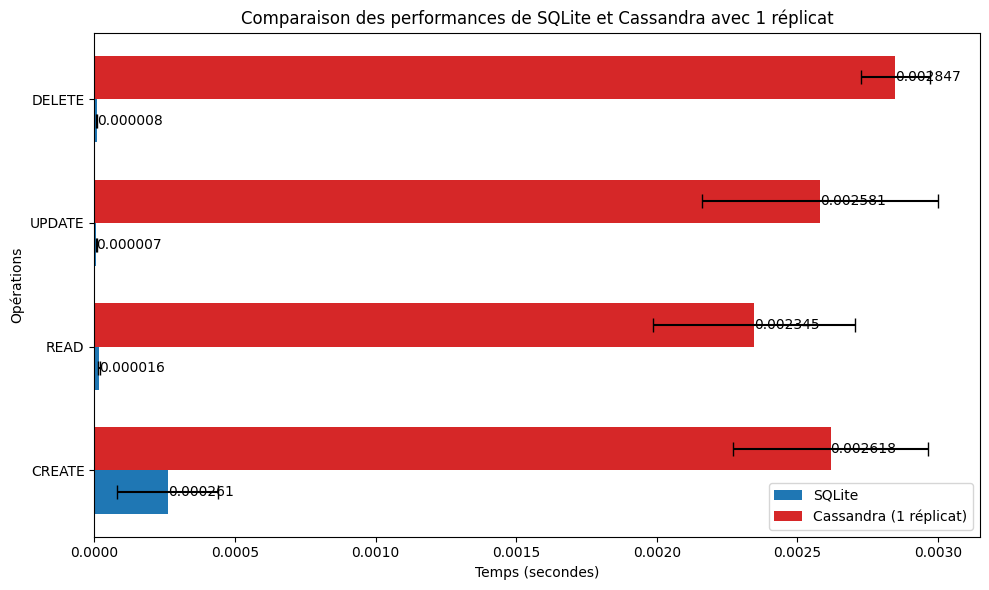

In [22]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_simple_mean_time, create_sqlite_simple_std_time),
    'READ': (read_sqlite_simple_mean_time, read_sqlite_simple_std_time),
    'UPDATE': (update_sqlite_simple_mean_time, update_sqlite_simple_std_time),
    'DELETE': (delete_sqlite_simple_mean_time, delete_sqlite_simple_std_time)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cassandra_simple_mean_time, create_cassandra_simple_std_time),
    'READ': (read_cassandra_simple_mean_time, read_cassandra_simple_std_time),
    'UPDATE': (update_cassandra_simple_mean_time, update_cassandra_simple_std_time),
    'DELETE': (delete_cassandra_simple_mean_time, delete_cassandra_simple_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat') 
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()


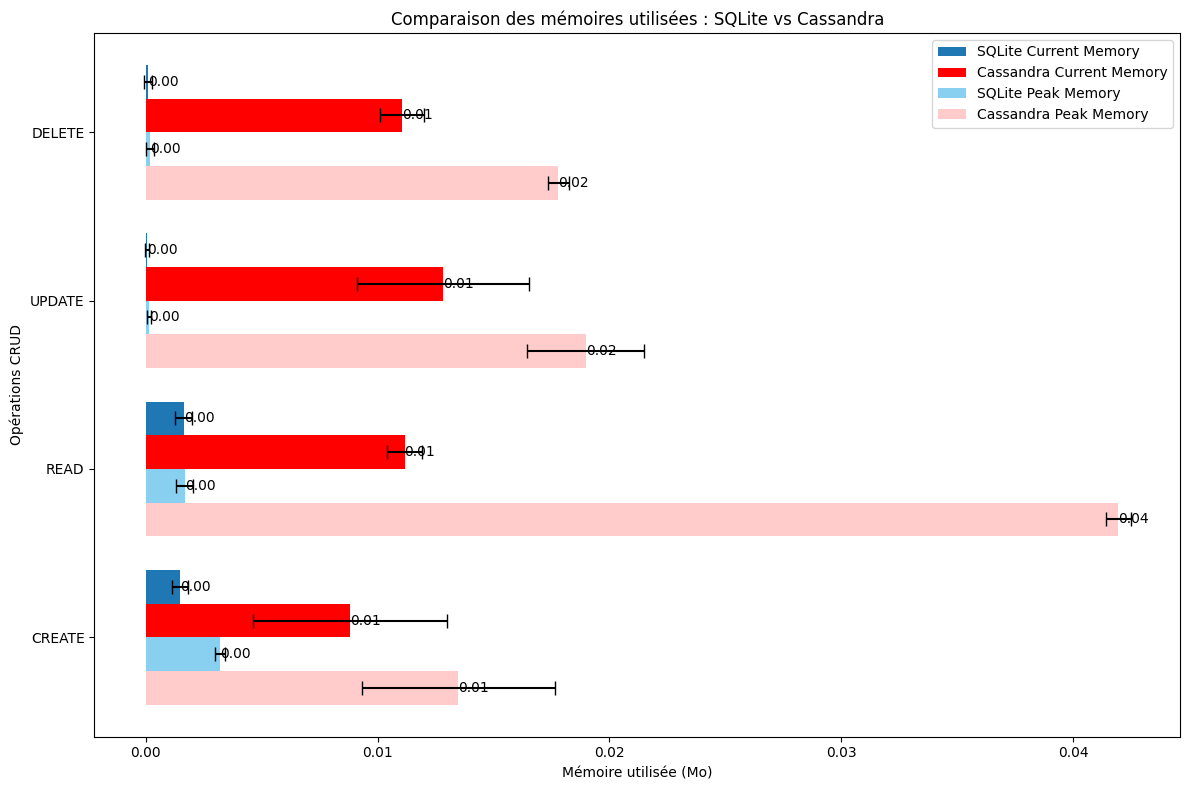

In [23]:
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_simple_mean_current_memory, create_sqlite_simple_std_current_memory),
               'peak': (create_sqlite_simple_mean_peak_memory, create_sqlite_simple_std_peak_memory)},
    'READ': {'current': (read_sqlite_simple_mean_current_memory, read_sqlite_simple_std_current_memory),
             'peak': (read_sqlite_simple_mean_peak_memory, read_sqlite_simple_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_simple_mean_current_memory, update_sqlite_simple_std_current_memory),
               'peak': (update_sqlite_simple_mean_peak_memory, update_sqlite_simple_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_simple_mean_current_memory, delete_sqlite_simple_std_current_memory),
               'peak': (delete_sqlite_simple_mean_peak_memory, delete_sqlite_simple_std_peak_memory)}
}

cassandra_memory = {
    'CREATE': {'current': (create_cassandra_simple_mean_current_memory, create_cassandra_simple_std_current_memory),
               'peak': (create_cassandra_simple_mean_peak_memory, create_cassandra_simple_std_peak_memory)},
    'READ': {'current': (read_cassandra_simple_mean_current_memory, read_cassandra_simple_std_current_memory),
             'peak': (read_cassandra_simple_mean_peak_memory, read_cassandra_simple_std_peak_memory)},
    'UPDATE': {'current': (update_cassandra_simple_mean_current_memory, update_cassandra_simple_std_current_memory),
               'peak': (update_cassandra_simple_mean_peak_memory, update_cassandra_simple_std_peak_memory)},
    'DELETE': {'current': (delete_cassandra_simple_mean_current_memory, delete_cassandra_simple_std_current_memory),
               'peak': (delete_cassandra_simple_mean_peak_memory, delete_cassandra_simple_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations))  
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5) # bleu clair
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCCB', capsize=5) # rouge clair

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()


En testant SQLite et Cassandra avec une seule ligne de données et une réplication pour Cassandra, on remarque des différences claires :
 
- SQLite :  
Ici, l'opération la plus lente est la création de la ligne de données. En revanche, les lectures, mises à jour et suppressions sont rapides, ce qui montre que SQLite est bien optimisé pour des petits volumes de données.  
- Cassandra :  
La lecture est l'opération la plus rapide, ce qui correspond bien à la manière dont Cassandra est conçu pour gérer les requêtes en lecture.  
Les mises à jour et suppressions prennent à peu près le même temps, et sont un peu plus rapides que la création.  
La création, par contre, est la plus lente, probablement à cause de la gestion de la réplication et des contraintes liées à son architecture distribuée.    

On fait le même constat concernant la mémoire (current et peak), où Cassandra est beaucoup plus gourmand que SQLite, notamment avec un pic énorme en lecture pour Cassandra.

Globalement, avec une seule ligne de données, Cassandra est beaucoup plus lent que SQLite. Cela s’explique par son architecture distribuée, qui ajoute un overhead même dans des contextes simples, et par ses mécanismes de réplication et de gestion des partitions, conçus pour des scénarios à grande échelle. En revanche, SQLite, étant une solution locale et légère, est optimisé pour des opérations rapides sur de petites bases de données.


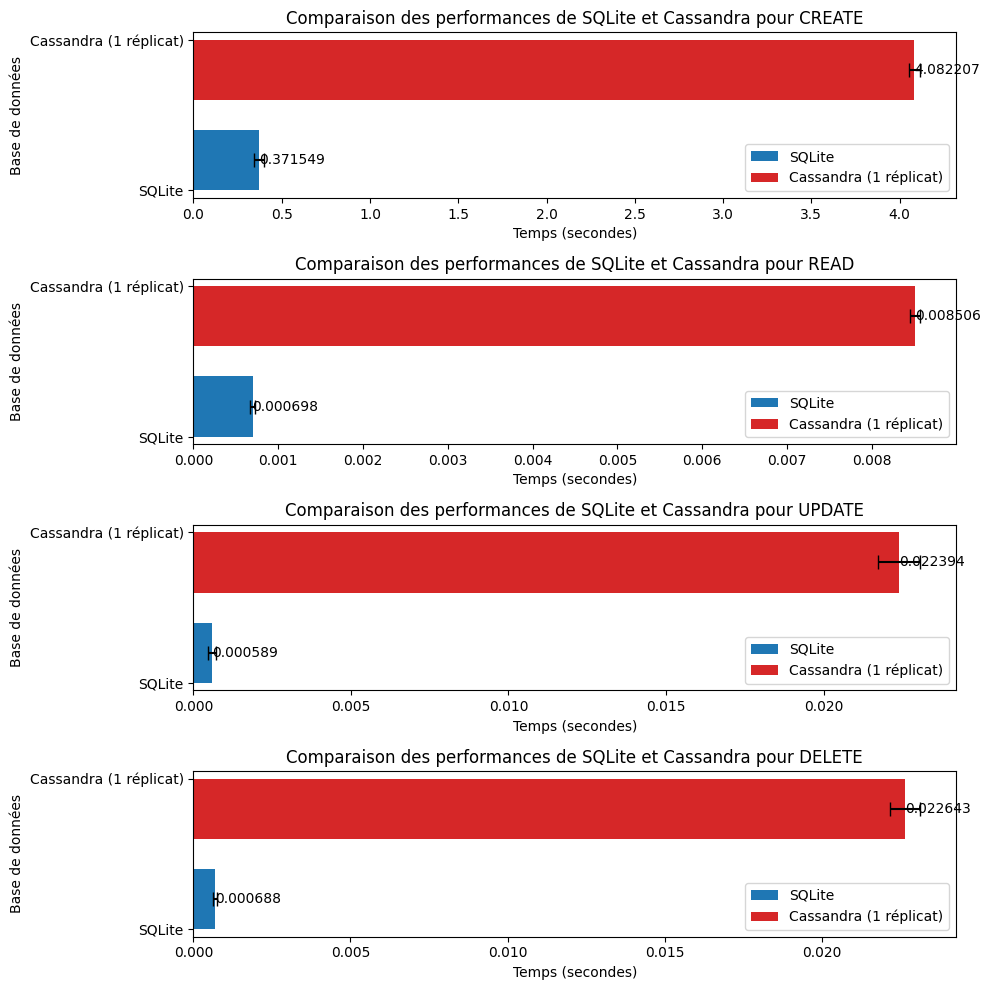

In [24]:
# Données des temps de SQLite et Cassandra pour chaque opération
sqlite_times = {
    'CREATE': (create_sqlite_initial_mean_time, create_sqlite_initial_std_time),
    'READ': (read_sqlite_initial_mean_time, read_sqlite_initial_std_time),
    'UPDATE': (update_sqlite_initial_mean_time, update_sqlite_initial_std_time),
    'DELETE': (delete_sqlite_initial_mean_time, delete_sqlite_initial_std_time)
}

cassandra_times = {
    'CREATE': (create_cassandra_initial_mean_time, create_cassandra_initial_std_time),
    'READ': (read_cassandra_initial_mean_time, read_cassandra_initial_std_time),
    'UPDATE': (update_cassandra_initial_mean_time, update_cassandra_initial_std_time),
    'DELETE': (delete_cassandra_initial_mean_time, delete_cassandra_initial_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

fig, axes = plt.subplots(4, 1, figsize=(10, 10))  
height = 0.4

for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(2)  

    bars1 = ax.barh(y[0] + height / 2, sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] - height / 2, cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)'])
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

plt.tight_layout()
plt.show()


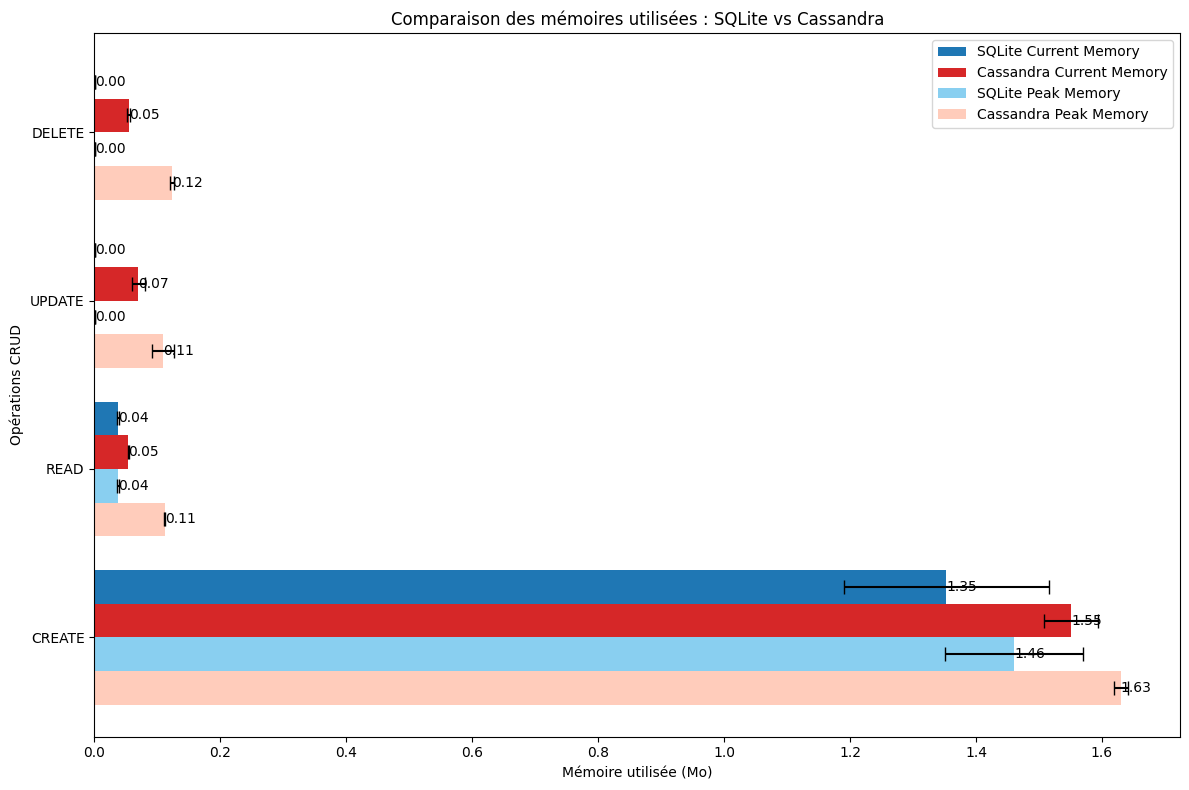

In [25]:
# Valeurs de mémoire pour SQLite (current et peak)
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_initial_mean_current_memory, create_sqlite_initial_std_current_memory),
               'peak': (create_sqlite_initial_mean_peak_memory, create_sqlite_initial_std_peak_memory)},
    'READ': {'current': (read_sqlite_initial_mean_current_memory, read_sqlite_initial_std_current_memory),
             'peak': (read_sqlite_initial_mean_peak_memory, read_sqlite_initial_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_initial_mean_current_memory, update_sqlite_initial_std_current_memory),
               'peak': (update_sqlite_initial_mean_peak_memory, update_sqlite_initial_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_initial_mean_current_memory, delete_sqlite_initial_std_current_memory),
               'peak': (delete_sqlite_initial_mean_peak_memory, delete_sqlite_initial_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra (current et peak)
cassandra_memory = {
    'CREATE': {'current': (create_cassandra_initial_mean_current_memory, create_cassandra_initial_std_current_memory),
               'peak': (create_cassandra_initial_mean_peak_memory, create_cassandra_initial_std_peak_memory)},
    'READ': {'current': (read_cassandra_initial_mean_current_memory, read_cassandra_initial_std_current_memory),
             'peak': (read_cassandra_initial_mean_peak_memory, read_cassandra_initial_std_peak_memory)},
    'UPDATE': {'current': (update_cassandra_initial_mean_current_memory, update_cassandra_initial_std_current_memory),
               'peak': (update_cassandra_initial_mean_peak_memory, update_cassandra_initial_std_peak_memory)},
    'DELETE': {'current': (delete_cassandra_initial_mean_current_memory, delete_cassandra_initial_std_current_memory),
               'peak': (delete_cassandra_initial_mean_peak_memory, delete_cassandra_initial_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations)) 
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='tab:red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5)
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCBB', capsize=5)

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()

En analysant les échelles de temps, plusieurs observations se dégagent. Cassandra affiche systématiquement des temps d'exécution plus longs que SQLite, quelle que soit l'opération effectuée. Pour les deux bases de données, l'opération CREATE est toujours la plus longue, tandis que READ est la plus rapide pour Cassandra. Les temps des opérations UPDATE et DELETE sont comparables pour Cassandra. Du côté de SQLite, les opérations UPDATE et DELETE consomment très peu de mémoire, tandis que READ est légèrement plus exigeante. Cependant, SQLite utilise globalement davantage de mémoire (current et peak, entre 1.3 et 1.4 fois plus) pour l'ensemble des opérations. Enfin, l'opération CREATE nécessite une quantité de mémoire similaire pour Cassandra et SQLite.

## Comparaison des temps de Cassandra avec plusieurs replicaSet

##### NB : Qu'est ce que *SimpleStrategy* ?
Description : Réplique les données de manière linéaire sur les n nœuds du cluster, où n est le replication_factor.
- Avantages :
    - Simple à configurer.
    - Adapté aux environnements de test ou aux clusters d'une seule région.
- Inconvénients :
    - Pas optimisé pour les déploiements multi-régions.
    - Répartition des réplicas pas toujours équilibrée en cas de cluster complexe.

In [26]:
# 2 replicas
# --- CREATE ---
create_cassandra_initial_mean_time_2, create_cassandra_initial_std_time_2, \
    create_cassandra_initial_mean_current_memory_2, create_cassandra_initial_std_current_memory_2, \
        create_cassandra_initial_mean_peak_memory_2, create_cassandra_initial_std_peak_memory_2 = benchmark_operation(cassandra_insert, df_initial, 2)

# --- READ ---
read_cassandra_initial_mean_time_2, read_cassandra_initial_std_time_2, \
    read_cassandra_initial_mean_current_memory_2, read_cassandra_initial_std_current_memory_2, \
        read_cassandra_initial_mean_peak_memory_2, read_cassandra_initial_std_peak_memory_2 = benchmark_operation(cassandra_read, df_initial, 2)

# --- UPDATE ---
update_cassandra_initial_mean_time_2, update_cassandra_initial_std_time_2, \
    update_cassandra_initial_mean_current_memory_2, update_cassandra_initial_std_current_memory_2, \
        update_cassandra_initial_mean_peak_memory_2, update_cassandra_initial_std_peak_memory_2 = benchmark_operation(cassandra_update, df_initial, 2)

# --- DELETE ---
delete_cassandra_initial_mean_time_2, delete_cassandra_initial_std_time_2, \
    delete_cassandra_initial_mean_current_memory_2, delete_cassandra_initial_std_current_memory_2, \
        delete_cassandra_initial_mean_peak_memory_2, delete_cassandra_initial_std_peak_memory_2 = benchmark_operation(cassandra_delete, df_initial, 2)

replication factor = 2
Create Time: 4.068082 seconds
Current memory usage is 1.4770574569702148Mo; Peak was 1.6395702362060547Mo
replication factor = 2
Create Time: 4.106127 seconds
Current memory usage is 1.5557823181152344Mo; Peak was 1.624180793762207Mo
replication factor = 2
Create Time: 4.082963 seconds
Current memory usage is 1.5284862518310547Mo; Peak was 1.6379022598266602Mo
replication factor = 2
Create Time: 4.058528 seconds
Current memory usage is 1.4755449295043945Mo; Peak was 1.6221847534179688Mo
replication factor = 2
Create Time: 4.065082 seconds
Current memory usage is 1.5885238647460938Mo; Peak was 1.6352386474609375Mo
replication factor = 2
Create Time: 4.117278 seconds
Current memory usage is 1.5212888717651367Mo; Peak was 1.6217231750488281Mo
Read Time: 0.008584 seconds
Queried 37 records
Current memory usage is 0.057152748107910156Mo; Peak was 0.11367416381835938Mo
replication factor = 2
Create Time: 4.030853 seconds
Current memory usage is 1.5574464797973633Mo; Pe

In [27]:
# 5 replicas
# --- CREATE ---
create_cassandra_initial_mean_time_5, create_cassandra_initial_std_time_5, \
    create_cassandra_initial_mean_current_memory_5, create_cassandra_initial_std_current_memory_5, \
        create_cassandra_initial_mean_peak_memory_5, create_cassandra_initial_std_peak_memory_5 = benchmark_operation(cassandra_insert, df_initial, 5)

# --- READ ---
read_cassandra_initial_mean_time_5, read_cassandra_initial_std_time_5, \
    read_cassandra_initial_mean_current_memory_5, read_cassandra_initial_std_current_memory_5, \
        read_cassandra_initial_mean_peak_memory_5, read_cassandra_initial_std_peak_memory_5 = benchmark_operation(cassandra_read, df_initial, 5)

# --- UPDATE ---
update_cassandra_initial_mean_time_5, update_cassandra_initial_std_time_5, \
    update_cassandra_initial_mean_current_memory_5, update_cassandra_initial_std_current_memory_5, \
        update_cassandra_initial_mean_peak_memory_5, update_cassandra_initial_std_peak_memory_5 = benchmark_operation(cassandra_update, df_initial, 5)

# --- DELETE ---
delete_cassandra_initial_mean_time_5, delete_cassandra_initial_std_time_5, \
    delete_cassandra_initial_mean_current_memory_5, delete_cassandra_initial_std_current_memory_5, \
        delete_cassandra_initial_mean_peak_memory_5, delete_cassandra_initial_std_peak_memory_5 = benchmark_operation(cassandra_delete, df_initial, 5)

replication factor = 5
Create Time: 4.089206 seconds
Current memory usage is 1.5372400283813477Mo; Peak was 1.6212406158447266Mo
replication factor = 5
Create Time: 4.057425 seconds
Current memory usage is 1.4885272979736328Mo; Peak was 1.6206951141357422Mo
replication factor = 5
Create Time: 4.065723 seconds
Current memory usage is 1.5893497467041016Mo; Peak was 1.6230649948120117Mo
replication factor = 5
Create Time: 4.094151 seconds
Current memory usage is 1.5361146926879883Mo; Peak was 1.6233940124511719Mo
replication factor = 5
Create Time: 4.074848 seconds
Current memory usage is 1.493514060974121Mo; Peak was 1.6210756301879883Mo
replication factor = 5
Create Time: 4.034785 seconds
Current memory usage is 1.4582176208496094Mo; Peak was 1.6162748336791992Mo
Read Time: 0.008552 seconds
Queried 37 records
Current memory usage is 0.05286884307861328Mo; Peak was 0.1107330322265625Mo
replication factor = 5
Create Time: 4.139573 seconds
Current memory usage is 1.4490842819213867Mo; Peak

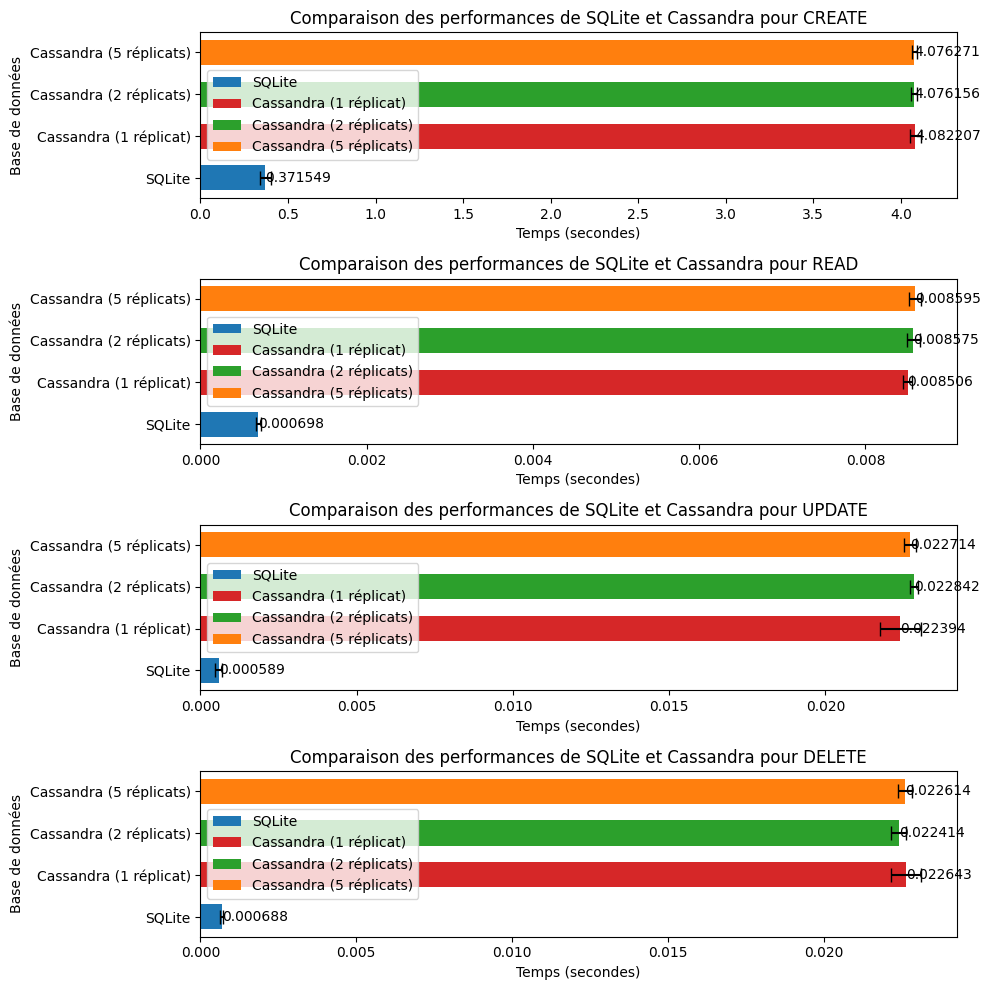

In [28]:
# Données des temps pour SQLite et Cassandra
sqlite_times = {
    'CREATE': (create_sqlite_initial_mean_time, create_sqlite_initial_std_time),
    'READ': (read_sqlite_initial_mean_time, read_sqlite_initial_std_time),
    'UPDATE': (update_sqlite_initial_mean_time, update_sqlite_initial_std_time),
    'DELETE': (delete_sqlite_initial_mean_time, delete_sqlite_initial_std_time)
}

cassandra_times = {
    'CREATE': (create_cassandra_initial_mean_time, create_cassandra_initial_std_time),
    'READ': (read_cassandra_initial_mean_time, read_cassandra_initial_std_time),
    'UPDATE': (update_cassandra_initial_mean_time, update_cassandra_initial_std_time),
    'DELETE': (delete_cassandra_initial_mean_time, delete_cassandra_initial_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_initial_mean_time_2, create_cassandra_initial_std_time_2),
    'READ': (read_cassandra_initial_mean_time_2, read_cassandra_initial_std_time_2),
    'UPDATE': (update_cassandra_initial_mean_time_2, update_cassandra_initial_std_time_2),
    'DELETE': (delete_cassandra_initial_mean_time_2, delete_cassandra_initial_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_initial_mean_time_5, create_cassandra_initial_std_time_5),
    'READ': (read_cassandra_initial_mean_time_5, read_cassandra_initial_std_time_5),
    'UPDATE': (update_cassandra_initial_mean_time_5, update_cassandra_initial_std_time_5),
    'DELETE': (delete_cassandra_initial_mean_time_5, delete_cassandra_initial_std_time_5)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les moyennes et les écarts-types pour chaque opération
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

# Créer un graphique pour chaque opération
fig, axes = plt.subplots(4, 1, figsize=(10, 10))  # 4 graphiques sous le même format
height = 0.6

# Générer chaque sous-graphe pour chaque opération
for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(4)  # Quatre barres par graphique : SQLite, Cassandra (1), (2) et (5) réplicats

    # Dessiner les barres pour SQLite et Cassandra avec différents réplicats
    bars1 = ax.barh(y[0] , sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] , cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
    bars3 = ax.barh(y[2], cassandra_times_2[op][0], height, xerr=cassandra_times_2[op][1], label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
    bars4 = ax.barh(y[3], cassandra_times_5[op][0], height, xerr=cassandra_times_5[op][1], label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

    # Titre et labels
    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)', 'Cassandra (2 réplicats)', 'Cassandra (5 réplicats)'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)
    add_values(bars3)
    add_values(bars4)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


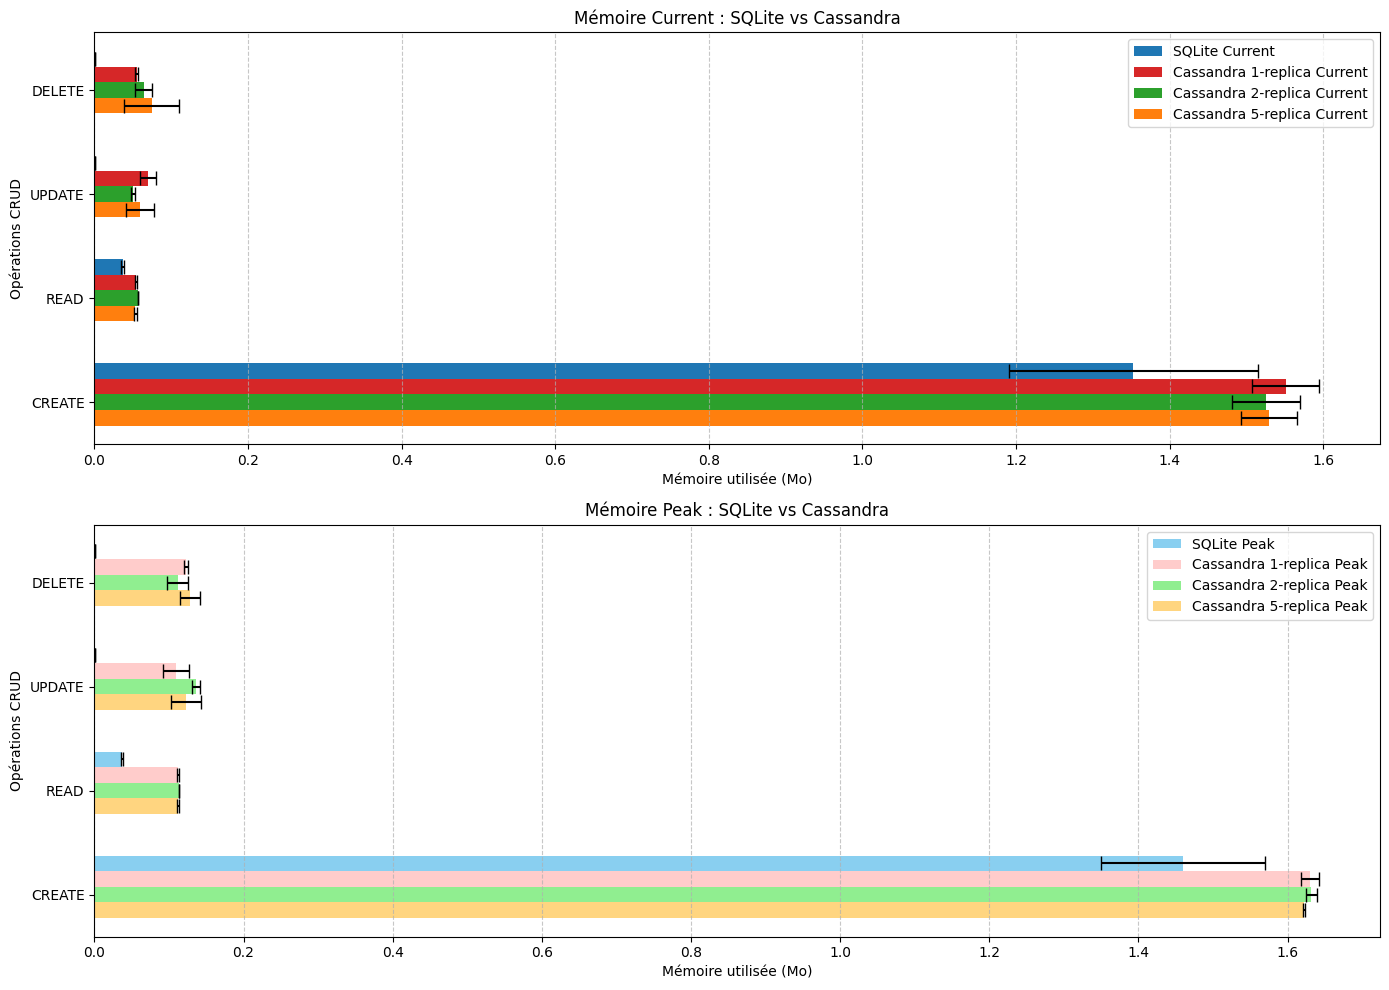

In [29]:
# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_initial_mean_current_memory, create_sqlite_initial_std_current_memory),
               'peak': (create_sqlite_initial_mean_peak_memory, create_sqlite_initial_std_peak_memory)},
    'READ': {'current': (read_sqlite_initial_mean_current_memory, read_sqlite_initial_std_current_memory),
             'peak': (read_sqlite_initial_mean_peak_memory, read_sqlite_initial_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_initial_mean_current_memory, update_sqlite_initial_std_current_memory),
               'peak': (update_sqlite_initial_mean_peak_memory, update_sqlite_initial_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_initial_mean_current_memory, delete_sqlite_initial_std_current_memory),
               'peak': (delete_sqlite_initial_mean_peak_memory, delete_sqlite_initial_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cassandra_initial_mean_current_memory, create_cassandra_initial_std_current_memory),
                   'peak': (create_cassandra_initial_mean_peak_memory, create_cassandra_initial_std_peak_memory)},
        'READ': {'current': (read_cassandra_initial_mean_current_memory, read_cassandra_initial_std_current_memory),
                 'peak': (read_cassandra_initial_mean_peak_memory, read_cassandra_initial_std_peak_memory)},
        'UPDATE': {'current': (update_cassandra_initial_mean_current_memory, update_cassandra_initial_std_current_memory),
                   'peak': (update_cassandra_initial_mean_peak_memory, update_cassandra_initial_std_peak_memory)},
        'DELETE': {'current': (delete_cassandra_initial_mean_current_memory, delete_cassandra_initial_std_current_memory),
                   'peak': (delete_cassandra_initial_mean_peak_memory, delete_cassandra_initial_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_initial_mean_current_memory_2, create_cassandra_initial_std_current_memory_2),
                   'peak': (create_cassandra_initial_mean_peak_memory_2, create_cassandra_initial_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_initial_mean_current_memory_2, read_cassandra_initial_std_current_memory_2),
                 'peak': (read_cassandra_initial_mean_peak_memory_2, read_cassandra_initial_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_initial_mean_current_memory_2, update_cassandra_initial_std_current_memory_2),
                   'peak': (update_cassandra_initial_mean_peak_memory_2, update_cassandra_initial_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_initial_mean_current_memory_2, delete_cassandra_initial_std_current_memory_2),
                   'peak': (delete_cassandra_initial_mean_peak_memory_2, delete_cassandra_initial_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_initial_mean_current_memory_5, create_cassandra_initial_std_current_memory_5),
                   'peak': (create_cassandra_initial_mean_peak_memory_5, create_cassandra_initial_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_initial_mean_current_memory_5, read_cassandra_initial_std_current_memory_5),
                 'peak': (read_cassandra_initial_mean_peak_memory_5, read_cassandra_initial_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_initial_mean_current_memory_5, update_cassandra_initial_std_current_memory_5),
                   'peak': (update_cassandra_initial_mean_peak_memory_5, update_cassandra_initial_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_initial_mean_current_memory_5, delete_cassandra_initial_std_current_memory_5),
                   'peak': (delete_cassandra_initial_mean_peak_memory_5, delete_cassandra_initial_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


Le constat est similaire à celui des tests précédents : SQLite se révèle nettement plus rapide que Cassandra dans la gestion des données, avec une performance de lecture plus rapide en Cassandra que les opérations de mise à jour et de suppression.

Sur les deux systèmes, l'opération de création (create) reste la plus longue, quel que soit le contexte.

Avec plusieurs replica sets, les différences de temps d'exécution sont négligeables. En tenant compte de l'erreur standard, les temps mesurés pour Cassandra avec 1, 2 et 5 réplicas sont pratiquement identiques. Il en va de même pour la consommation de mémoire, qui reste comparable quel que soit le nombre de réplicas.

# Création d'un dataset plus grand

Utiliser une base de données plus grande : Cassandra est mieux adapté pour gérer de grandes quantités de données et pour tirer parti de son architecture distribuée.
On va donc augmenter notre jeu de données 

On crée nous même ce dataset car les sites de création de dataset ne permettent de télécharger que 1000 lignes avec un compte gratuit.

In [30]:
df_initial.shape

(8807, 12)

In [31]:
original_df = df_initial 

num_rows = 30000

def generate_large_column(original_column, size):
    return [random.choice(original_column) for _ in range(size)]

def generate_unique_show_id(existing_ids, size):
    start_id = max(existing_ids) + 1 if existing_ids else 1
    return [f"{i}" for i in range(start_id, start_id + size)]

generated_data = original_df.to_dict(orient='list')  

existing_ids = set(map(int, original_df["show_id"].tolist())) 
new_ids = generate_unique_show_id(existing_ids, num_rows - len(original_df))
generated_data["show_id"].extend(new_ids)

for column in original_df.columns:
    if column != "show_id":  
        generated_data[column].extend(generate_large_column(original_df[column].tolist(), num_rows - len(original_df)))

large_df = pd.DataFrame(generated_data)

large_df = large_df.drop_duplicates()

for column in large_df.columns:
    if large_df[column].isnull().any():
        if large_df[column].dtype == "object":
            large_df[column].fillna("Unknown", inplace=True)  
        else:
            large_df[column].fillna(0, inplace=True)  

large_df = large_df.drop_duplicates()

if large_df["show_id"].duplicated().any():
    print("Attention : Des doublons existent dans la colonne 'show_id'.")
else:
    print("Les IDs sont uniques.")

output_file = "netflix_titles_large.csv"
large_df.to_csv(output_file, index=False)
print(f"Dataset généré avec {len(large_df)} lignes (lignes dupliquées supprimées) et exporté dans {output_file}.")


Les IDs sont uniques.
Dataset généré avec 30000 lignes (lignes dupliquées supprimées) et exporté dans netflix_titles_large.csv.


In [32]:
large_df.shape

(30000, 12)

In [33]:
# Caster correctement les colonnes 
large_df['show_id'] = large_df['show_id'].astype(int)

large_df['show_id'] = large_df['show_id'].astype(int)
large_df['release_year'] = large_df['release_year'].astype(int)

large_df['type'] = large_df['title'].astype(str)
large_df['title'] = large_df['title'].astype(str)
large_df['director'] = large_df['director'].astype(str)
large_df['cast'] = large_df['cast'].astype(str)
large_df['country'] = large_df['country'].astype(str)
large_df['date_added'] = large_df['date_added'].astype(str)
large_df['rating'] = large_df['rating'].astype(str)
large_df['duration'] = large_df['duration'].astype(str)
large_df['listed_in'] = large_df['listed_in'].astype(str)
large_df['description'] = large_df['description'].astype(str)

In [34]:
# sqlite 
# --- CREATE ---
create_sqlite_large_mean_time, create_sqlite_large_std_time, \
    create_sqlite_large_mean_current_memory, create_sqlite_large_std_current_memory, \
        create_sqlite_large_mean_peak_memory, create_sqlite_large_std_peak_memory = benchmark_operation(sqlite_insert, large_df)

# --- READ ---
read_sqlite_large_mean_time, read_sqlite_large_std_time, \
    read_sqlite_large_mean_current_memory, read_sqlite_large_std_current_memory, \
        read_sqlite_large_mean_peak_memory, read_sqlite_large_std_peak_memory = benchmark_operation(sqlite_read, large_df)

# --- UPDATE ---
update_sqlite_large_mean_time, update_sqlite_large_std_time, \
    update_sqlite_large_mean_current_memory, update_sqlite_large_std_current_memory, \
        update_sqlite_large_mean_peak_memory, update_sqlite_large_std_peak_memory = benchmark_operation(sqlite_update, large_df)

# --- DELETE ---
delete_sqlite_large_mean_time, delete_sqlite_large_std_time, \
    delete_sqlite_large_mean_current_memory, delete_sqlite_large_std_current_memory, \
        delete_sqlite_large_mean_peak_memory, delete_sqlite_large_std_peak_memory = benchmark_operation(sqlite_delete, large_df)

Create Time: 1.305178 seconds
Current memory usage is 4.345832824707031Mo; Peak was 4.802192687988281Mo
Create Time: 1.256518 seconds
Current memory usage is 4.344351768493652Mo; Peak was 4.80078125Mo
Create Time: 1.325498 seconds
Current memory usage is 4.3442583084106445Mo; Peak was 4.80078125Mo
Create Time: 1.296202 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.307091 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.307871 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.003984 seconds
Queried 134 records
Current memory usage is 0.14043521881103516Mo; Peak was 0.14043521881103516Mo
Create Time: 1.311663 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.002791 seconds
Queried 134 records
Current memory usage is 0.12239933013916016Mo; Peak was 0.12239933013916016Mo
Create Time: 1.307863 seconds
Current memory usage is 4.34362

In [35]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_large_mean_time, create_cassandra_large_std_time, \
    create_cassandra_large_mean_current_memory, create_cassandra_large_std_current_memory, \
        create_cassandra_large_mean_peak_memory, create_cassandra_large_std_peak_memory = benchmark_operation(cassandra_insert, large_df, 1)

# --- READ ---
read_cassandra_large_mean_time, read_cassandra_large_std_time, \
    read_cassandra_large_mean_current_memory, read_cassandra_large_std_current_memory, \
        read_cassandra_large_mean_peak_memory, read_cassandra_large_std_peak_memory = benchmark_operation(cassandra_read, large_df, 1)

# --- UPDATE ---
update_cassandra_large_mean_time, update_cassandra_large_std_time, \
    update_cassandra_large_mean_current_memory, update_cassandra_large_std_current_memory, \
        update_cassandra_large_mean_peak_memory, update_cassandra_large_std_peak_memory = benchmark_operation(cassandra_update, large_df, 1)

# --- DELETE ---
delete_cassandra_large_mean_time, delete_cassandra_large_std_time, \
    delete_cassandra_large_mean_current_memory, delete_cassandra_large_std_current_memory, \
        delete_cassandra_large_mean_peak_memory, delete_cassandra_large_std_peak_memory = benchmark_operation(cassandra_delete, large_df, 1)

replication factor = 1
Create Time: 14.107633 seconds
Current memory usage is 4.688434600830078Mo; Peak was 4.807888031005859Mo
replication factor = 1
Create Time: 13.920688 seconds
Current memory usage is 4.798870086669922Mo; Peak was 4.951694488525391Mo
replication factor = 1
Create Time: 13.814156 seconds
Current memory usage is 4.895030975341797Mo; Peak was 4.942122459411621Mo
replication factor = 1
Create Time: 13.891937 seconds
Current memory usage is 4.812722206115723Mo; Peak was 4.95905876159668Mo
replication factor = 1
Create Time: 14.025427 seconds
Current memory usage is 4.880401611328125Mo; Peak was 4.945127487182617Mo
replication factor = 1
Create Time: 14.464603 seconds
Current memory usage is 4.853646278381348Mo; Peak was 4.93635368347168Mo
Read Time: 0.028117 seconds
Queried 134 records
Current memory usage is 0.16408729553222656Mo; Peak was 0.3663520812988281Mo
replication factor = 1
Create Time: 14.028974 seconds
Current memory usage is 4.853952407836914Mo; Peak was 4

In [36]:
# 2 replicas
# --- CREATE ---
create_cassandra_large_mean_time_2, create_cassandra_large_std_time_2, \
    create_cassandra_large_mean_current_memory_2, create_cassandra_large_std_current_memory_2, \
        create_cassandra_large_mean_peak_memory_2, create_cassandra_large_std_peak_memory_2 = benchmark_operation(cassandra_insert, large_df, 2)

# --- READ ---
read_cassandra_large_mean_time_2, read_cassandra_large_std_time_2, \
    read_cassandra_large_mean_current_memory_2, read_cassandra_large_std_current_memory_2, \
        read_cassandra_large_mean_peak_memory_2, read_cassandra_large_std_peak_memory_2 = benchmark_operation(cassandra_read, large_df, 2)

# --- UPDATE ---
update_cassandra_large_mean_time_2, update_cassandra_large_std_time_2, \
    update_cassandra_large_mean_current_memory_2, update_cassandra_large_std_current_memory_2, \
        update_cassandra_large_mean_peak_memory_2, update_cassandra_large_std_peak_memory_2 = benchmark_operation(cassandra_update, large_df, 2)

# --- DELETE ---
delete_cassandra_large_mean_time_2, delete_cassandra_large_std_time_2, \
    delete_cassandra_large_mean_current_memory_2, delete_cassandra_large_std_current_memory_2, \
        delete_cassandra_large_mean_peak_memory_2, delete_cassandra_large_std_peak_memory_2 = benchmark_operation(cassandra_delete, large_df, 2)


replication factor = 2
Create Time: 13.967856 seconds
Current memory usage is 4.889211654663086Mo; Peak was 4.936692237854004Mo
replication factor = 2
Create Time: 13.829521 seconds
Current memory usage is 4.870688438415527Mo; Peak was 4.944897651672363Mo
replication factor = 2
Create Time: 13.867042 seconds
Current memory usage is 4.786284446716309Mo; Peak was 4.942944526672363Mo
replication factor = 2
Create Time: 13.858062 seconds
Current memory usage is 4.823310852050781Mo; Peak was 4.941587448120117Mo
replication factor = 2
Create Time: 13.874336 seconds
Current memory usage is 4.7931928634643555Mo; Peak was 4.942525863647461Mo
replication factor = 2
Create Time: 13.923305 seconds
Current memory usage is 4.825992584228516Mo; Peak was 4.9440155029296875Mo
Read Time: 0.027314 seconds
Queried 134 records
Current memory usage is 0.1651439666748047Mo; Peak was 0.36568450927734375Mo
replication factor = 2
Create Time: 13.891885 seconds
Current memory usage is 4.823423385620117Mo; Peak w

In [37]:
# 5 replicas
# --- CREATE ---
create_cassandra_large_mean_time_5, create_cassandra_large_std_time_5, \
    create_cassandra_large_mean_current_memory_5, create_cassandra_large_std_current_memory_5, \
        create_cassandra_large_mean_peak_memory_5, create_cassandra_large_std_peak_memory_5 = benchmark_operation(cassandra_insert, large_df, 5)

# --- READ ---
read_cassandra_large_mean_time_5, read_cassandra_large_std_time_5, \
    read_cassandra_large_mean_current_memory_5, read_cassandra_large_std_current_memory_5, \
        read_cassandra_large_mean_peak_memory_5, read_cassandra_large_std_peak_memory_5 = benchmark_operation(cassandra_read, large_df, 5)

# --- UPDATE ---
update_cassandra_large_mean_time_5, update_cassandra_large_std_time_5, \
    update_cassandra_large_mean_current_memory_5, update_cassandra_large_std_current_memory_5, \
        update_cassandra_large_mean_peak_memory_5, update_cassandra_large_std_peak_memory_5 = benchmark_operation(cassandra_update, large_df, 5)

# --- DELETE ---
delete_cassandra_large_mean_time_5, delete_cassandra_large_std_time_5, \
    delete_cassandra_large_mean_current_memory_5, delete_cassandra_large_std_current_memory_5, \
        delete_cassandra_large_mean_peak_memory_5, delete_cassandra_large_std_peak_memory_5 = benchmark_operation(cassandra_delete, large_df, 5)


replication factor = 5
Create Time: 14.223870 seconds
Current memory usage is 4.819451332092285Mo; Peak was 4.931177139282227Mo
replication factor = 5
Create Time: 13.727003 seconds
Current memory usage is 4.887795448303223Mo; Peak was 4.948267936706543Mo
replication factor = 5
Create Time: 13.931281 seconds
Current memory usage is 4.870937347412109Mo; Peak was 4.973318099975586Mo
replication factor = 5
Create Time: 13.916015 seconds
Current memory usage is 4.891016006469727Mo; Peak was 4.960564613342285Mo
replication factor = 5
Create Time: 13.787439 seconds
Current memory usage is 4.806285858154297Mo; Peak was 4.951393127441406Mo
replication factor = 5
Create Time: 13.793573 seconds
Current memory usage is 4.847027778625488Mo; Peak was 4.94300651550293Mo
Read Time: 0.027990 seconds
Queried 134 records
Current memory usage is 0.15935325622558594Mo; Peak was 0.36685943603515625Mo
replication factor = 5
Create Time: 13.961192 seconds
Current memory usage is 4.889833450317383Mo; Peak was

## Visualisation

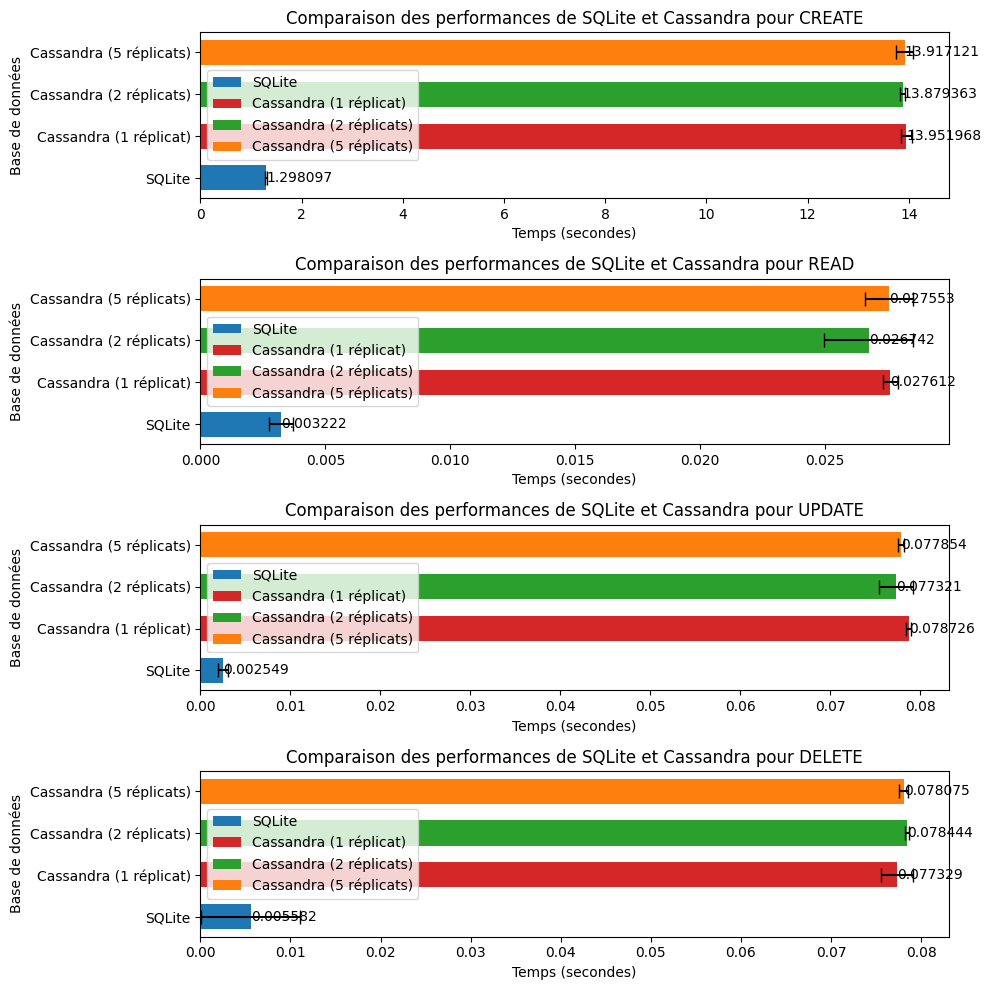

In [38]:
sqlite_times = {
    'CREATE': (create_sqlite_large_mean_time, create_sqlite_large_std_time),
    'READ': (read_sqlite_large_mean_time, read_sqlite_large_std_time),
    'UPDATE': (update_sqlite_large_mean_time, update_sqlite_large_std_time),
    'DELETE': (delete_sqlite_large_mean_time, delete_sqlite_large_std_time)
}

cassandra_times = {
    'CREATE': (create_cassandra_large_mean_time, create_cassandra_large_std_time),
    'READ': (read_cassandra_large_mean_time, read_cassandra_large_std_time),
    'UPDATE': (update_cassandra_large_mean_time, update_cassandra_large_std_time),
    'DELETE': (delete_cassandra_large_mean_time, delete_cassandra_large_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_large_mean_time_2, create_cassandra_large_std_time_2),
    'READ': (read_cassandra_large_mean_time_2, read_cassandra_large_std_time_2),
    'UPDATE': (update_cassandra_large_mean_time_2, update_cassandra_large_std_time_2),
    'DELETE': (delete_cassandra_large_mean_time_2, delete_cassandra_large_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_large_mean_time_5, create_cassandra_large_std_time_5),
    'READ': (read_cassandra_large_mean_time_5, read_cassandra_large_std_time_5),
    'UPDATE': (update_cassandra_large_mean_time_5, update_cassandra_large_std_time_5),
    'DELETE': (delete_cassandra_large_mean_time_5, delete_cassandra_large_std_time_5)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les temps moyens et écarts-types pour chaque système
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

# Créer un graphique pour chaque opération
fig, axes = plt.subplots(4, 1, figsize=(10, 10))  # 4 graphiques sous le même format
height = 0.6

# Générer chaque sous-graphe pour chaque opération
for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(4)  # Quatre barres par graphique : SQLite, Cassandra (1), (2) et (5) réplicats

    # Dessiner les barres pour SQLite et Cassandra avec différents réplicats
    bars1 = ax.barh(y[0] , sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] , cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
    bars3 = ax.barh(y[2], cassandra_times_2[op][0], height, xerr=cassandra_times_2[op][1], label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
    bars4 = ax.barh(y[3], cassandra_times_5[op][0], height, xerr=cassandra_times_5[op][1], label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

    # Titre et labels
    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)', 'Cassandra (2 réplicats)', 'Cassandra (5 réplicats)'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)
    add_values(bars3)
    add_values(bars4)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


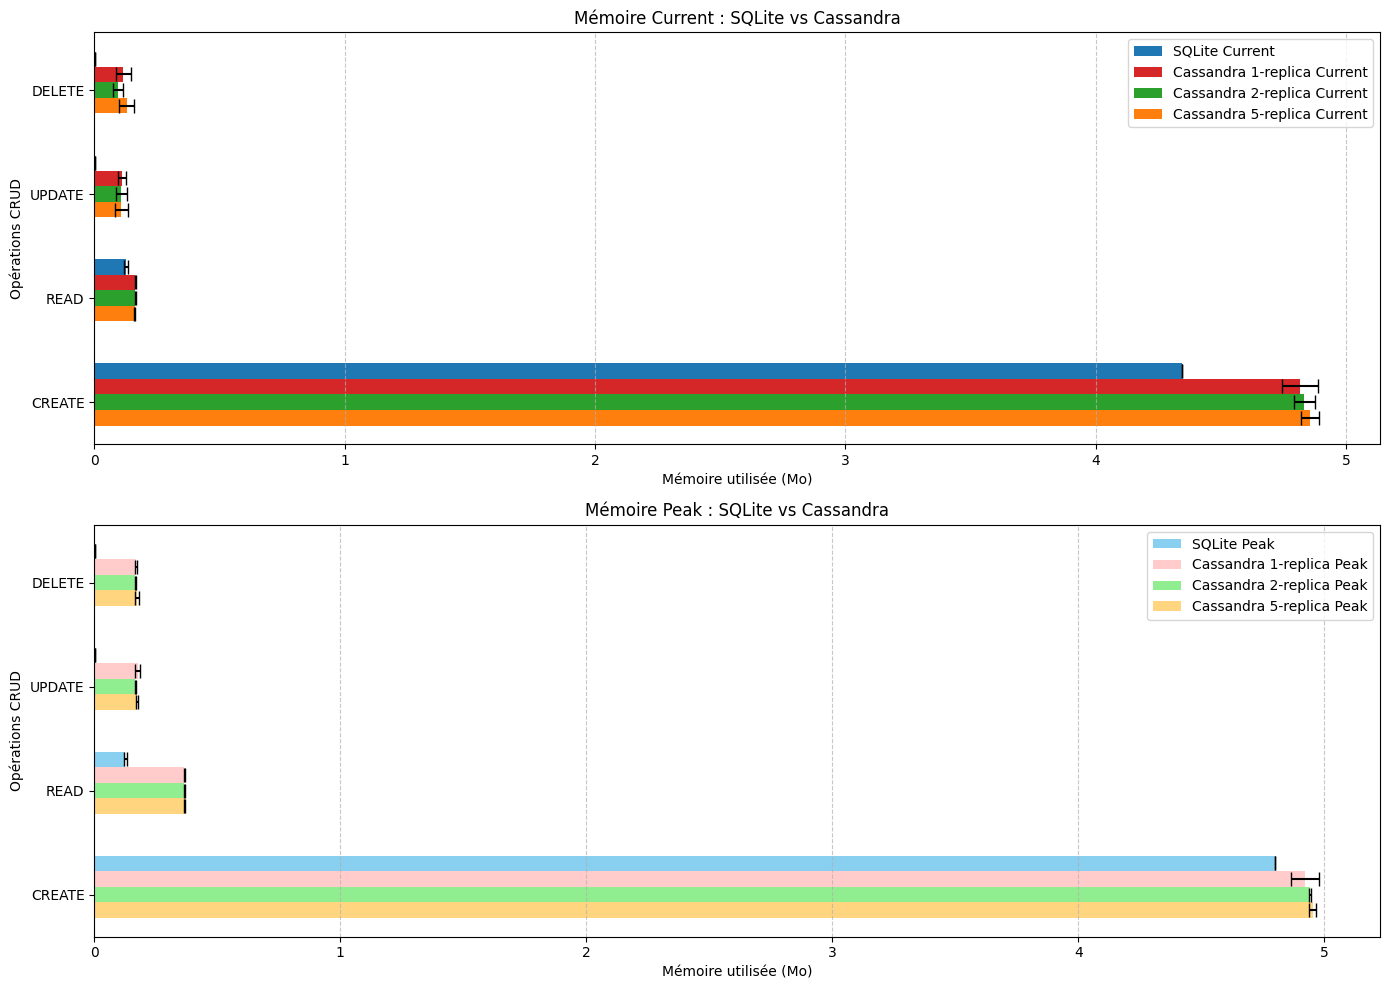

In [39]:
# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_large_mean_current_memory, create_sqlite_large_std_current_memory),
               'peak': (create_sqlite_large_mean_peak_memory, create_sqlite_large_std_peak_memory)},
    'READ': {'current': (read_sqlite_large_mean_current_memory, read_sqlite_large_std_current_memory),
             'peak': (read_sqlite_large_mean_peak_memory, read_sqlite_large_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_large_mean_current_memory, update_sqlite_large_std_current_memory),
               'peak': (update_sqlite_large_mean_peak_memory, update_sqlite_large_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_large_mean_current_memory, delete_sqlite_large_std_current_memory),
               'peak': (delete_sqlite_large_mean_peak_memory, delete_sqlite_large_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cassandra_large_mean_current_memory, create_cassandra_large_std_current_memory),
                   'peak': (create_cassandra_large_mean_peak_memory, create_cassandra_large_std_peak_memory)},
        'READ': {'current': (read_cassandra_large_mean_current_memory, read_cassandra_large_std_current_memory),
                 'peak': (read_cassandra_large_mean_peak_memory, read_cassandra_large_std_peak_memory)},
        'UPDATE': {'current': (update_cassandra_large_mean_current_memory, update_cassandra_large_std_current_memory),
                   'peak': (update_cassandra_large_mean_peak_memory, update_cassandra_large_std_peak_memory)},
        'DELETE': {'current': (delete_cassandra_large_mean_current_memory, delete_cassandra_large_std_current_memory),
                   'peak': (delete_cassandra_large_mean_peak_memory, delete_cassandra_large_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_large_mean_current_memory_2, create_cassandra_large_std_current_memory_2),
                   'peak': (create_cassandra_large_mean_peak_memory_2, create_cassandra_large_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_large_mean_current_memory_2, read_cassandra_large_std_current_memory_2),
                 'peak': (read_cassandra_large_mean_peak_memory_2, read_cassandra_large_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_large_mean_current_memory_2, update_cassandra_large_std_current_memory_2),
                   'peak': (update_cassandra_large_mean_peak_memory_2, update_cassandra_large_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_large_mean_current_memory_2, delete_cassandra_large_std_current_memory_2),
                   'peak': (delete_cassandra_large_mean_peak_memory_2, delete_cassandra_large_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_large_mean_current_memory_5, create_cassandra_large_std_current_memory_5),
                   'peak': (create_cassandra_large_mean_peak_memory_5, create_cassandra_large_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_large_mean_current_memory_5, read_cassandra_large_std_current_memory_5),
                 'peak': (read_cassandra_large_mean_peak_memory_5, read_cassandra_large_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_large_mean_current_memory_5, update_cassandra_large_std_current_memory_5),
                   'peak': (update_cassandra_large_mean_peak_memory_5, update_cassandra_large_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_large_mean_current_memory_5, delete_cassandra_large_std_current_memory_5),
                   'peak': (delete_cassandra_large_mean_peak_memory_5, delete_cassandra_large_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


Sur un dataset plus large, les résultats ne permettent pas de tirer des conclusions claires: les temps sont tous à peu près identiques entre  1, 2 et 5 replica sets pour une opération donnée. Côté mémoire, aucune variation notable n'a été observée entre les configurations. Globalement, l'augmentation de la taille des données, de 8k à 30k, n'apporte pas d'insights significatifs.

# Comparaison avec / sans index

### Index secondaires (clés secondaires)


Dans Cassandra, la commande `CREATE INDEX` permet de créer des index secondaires, qui ne sont pas des clés primaires. Cela permet de filtrer les données sur des colonnes autres que la partition key ou les clustering keys.

#### Avantages des index secondaires

- Facilite les filtres sur des colonnes non clés : Vous pouvez filtrer sur des colonnes autres que la partition key ou les clustering keys, ce qui rend les requêtes plus flexibles.
- Accès plus rapide aux données : Les index secondaires optimisent les requêtes qui filtrent sur certaines colonnes spécifiques, réduisant le nombre de partitions à examiner.

#### Inconvénients des index secondaires

- Risque de surcharge de performance : Sur de grandes tables, si une colonne contient beaucoup de valeurs distinctes, l'index peut devenir lourd et ralentir les performances des écritures et lectures.
- Structure distribuée moins efficace : Les index secondaires sont distribués, mais leur gestion est moins performante que les clés primaires, surtout sur des colonnes avec une haute cardinalité.
- Limitations d'usage : Les index secondaires sont mieux utilisés sur des colonnes avec faible cardinalité. Il est déconseillé de les utiliser pour des colonnes ayant une forte cardinalité ou pour des filtres complexes impliquant plusieurs colonnes.
- `ALLOW FILTERING` : Parfois, pour exécuter une requête avec un index secondaire (utilisation de `<` ou `>` par exemple), il est obligatoire d'utiliser `ALLOW FILTERING`, ce qui peut nuire aux performances en scannant une grande partie des données.

In [40]:
def cassandra_create_indexes(columns):
    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        index_query = f"CREATE INDEX {column}_idx ON shows ({column});"
        session.execute(index_query)
    cassandra_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return cassandra_time, current, peak


def sqlite_create_indexes(columns):
    # drop les index
    for column in columns:
        index_query = f"DROP INDEX IF EXISTS {column}_idx;"
        cursor.execute(index_query)

    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        # Créer une requête SQL pour chaque colonne
        index_query = f"CREATE INDEX IF NOT EXISTS {column}_idx ON shows ({column});"
        cursor.execute(index_query)
    sqlite_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return sqlite_time, current, peak

columns_to_index = ["release_year"]
cassandra_time_index, cassandra_current_index, cassandra_peak_index = cassandra_create_indexes(columns_to_index)
sqlite_time_index, sqlite_current_index, sqlite_peak_index = sqlite_create_indexes(columns_to_index)

print(f"Indexation time: Cassandra {cassandra_time_index:.5f}s, SQLite {sqlite_time_index:.5f}s")
print(f"Current memory: Cassandra {cassandra_current_index:.5f}Mo, SQLite {sqlite_current_index:.5f}Mo")

Indexation time: Cassandra 0.17675s, SQLite 0.00783s
Current memory: Cassandra 0.04068Mo, SQLite 0.00044Mo


In [41]:
# Fonctions pour CRUD SQLite avec index

# --- CREATE ---
def sqlite_insert_index(df):
    drop_table_sqlite()
    create_table_sqlite()
    sqlite_create_indexes(columns_to_index)

    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [42]:
# Fonctions pour CRUD Cassandra avec index

# --- CREATE ---
def cassandra_insert_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)
    cassandra_create_indexes(columns_to_index)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak


# --- READ ---
def cassandra_read_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    result = session.execute('SELECT * FROM shows WHERE release_year = 2000 ;') # ici pas de allow filtering !
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read time with index: {read_time:.5f}s")
    num_records = sum(1 for _ in result)
    print(f"Number of records: {num_records}")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# Dans Cassandra, pour effectuer un UPDATE, il est nécessaire de spécifier la clé primaire complète (partition key + clustering key).
# Par conséquent, il n'est pas possible de mettre à jour des lignes en fonction de critères de recherche arbitraires, sauf si ces critères correspondent exactement à la clé primaire.

# --- UPDATE ---
def cassandra_update_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]
    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)
    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update time with index: {update_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak


# --- DELETE ---
def cassandra_delete_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]
    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)
    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete time with index: {delete_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [43]:
# sqlite 
# --- CREATE ---
create_sqlite_large_mean_time_index, create_sqlite_large_std_time_index, \
    create_sqlite_large_mean_current_memory_index, create_sqlite_large_std_current_memory_index, \
        create_sqlite_large_mean_peak_memory_index, create_sqlite_large_std_peak_memory_index = benchmark_operation(sqlite_insert_index, large_df)

# --- READ ---
read_sqlite_large_mean_time_index, read_sqlite_large_std_time_index, \
    read_sqlite_large_mean_current_memory_index, read_sqlite_large_std_current_memory_index, \
        read_sqlite_large_mean_peak_memory_index, read_sqlite_large_std_peak_memory_index = benchmark_operation(sqlite_read_index, large_df)

# --- UPDATE ---
update_sqlite_large_mean_time_index, update_sqlite_large_std_time_index, \
    update_sqlite_large_mean_current_memory_index, update_sqlite_large_std_current_memory_index, \
        update_sqlite_large_mean_peak_memory_index, update_sqlite_large_std_peak_memory_index = benchmark_operation(sqlite_update_index, large_df)

# --- DELETE ---
delete_sqlite_large_mean_time_index, delete_sqlite_large_std_time_index, \
    delete_sqlite_large_mean_current_memory_index, delete_sqlite_large_std_current_memory_index, \
        delete_sqlite_large_mean_peak_memory_index, delete_sqlite_large_std_peak_memory_index = benchmark_operation(sqlite_delete_index, large_df)

Create Time: 1.349567 seconds
Current memory usage is 4.377193450927734Mo; Peak was 4.80078125Mo
Create Time: 1.325668 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.349469 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.317671 seconds
Current memory usage is 4.344037055969238Mo; Peak was 4.80078125Mo
Create Time: 1.351858 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.350467 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.000808 seconds
Queried 134 records
Current memory usage is 0.1402902603149414Mo; Peak was 0.1402902603149414Mo
Create Time: 1.335281 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.000773 seconds
Queried 134 records
Current memory usage is 0.12239933013916016Mo; Peak was 0.12239933013916016Mo
Create Time: 1.332309 seconds
Current memory usage is 4.343626976013184

In [44]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_large_mean_time_index, create_cassandra_large_std_time_index, \
    create_cassandra_large_mean_current_memory_index, create_cassandra_large_std_current_memory_index, \
        create_cassandra_large_mean_peak_memory_index, create_cassandra_large_std_peak_memory_index = benchmark_operation(cassandra_insert_index, large_df, 1)

# --- READ ---
read_cassandra_large_mean_time_index, read_cassandra_large_std_time_index, \
    read_cassandra_large_mean_current_memory_index, read_cassandra_large_std_current_memory_index, \
        read_cassandra_large_mean_peak_memory_index, read_cassandra_large_std_peak_memory_index = benchmark_operation(cassandra_read_index, large_df, 1)

# --- UPDATE ---
update_cassandra_large_mean_time_index, update_cassandra_large_std_time_index, \
    update_cassandra_large_mean_current_memory_index, update_cassandra_large_std_current_memory_index, \
        update_cassandra_large_mean_peak_memory_index, update_cassandra_large_std_peak_memory_index = benchmark_operation(cassandra_update_index, large_df, 1)

# --- DELETE ---
delete_cassandra_large_mean_time_index, delete_cassandra_large_std_time_index, \
    delete_cassandra_large_mean_current_memory_index, delete_cassandra_large_std_current_memory_index, \
        delete_cassandra_large_mean_peak_memory_index, delete_cassandra_large_std_peak_memory_index = benchmark_operation(cassandra_delete_index, large_df, 1)

replication factor = 1
Create Time: 14.049651 seconds
Current memory usage is 4.759546279907227Mo; Peak was 4.949460983276367Mo
replication factor = 1
Create Time: 13.730568 seconds
Current memory usage is 4.829494476318359Mo; Peak was 4.956901550292969Mo
replication factor = 1
Create Time: 13.843877 seconds
Current memory usage is 4.7814435958862305Mo; Peak was 4.950384140014648Mo
replication factor = 1
Create Time: 13.890019 seconds
Current memory usage is 4.911746025085449Mo; Peak was 4.962780952453613Mo
replication factor = 1
Create Time: 13.936144 seconds
Current memory usage is 4.928504943847656Mo; Peak was 4.961515426635742Mo
replication factor = 1
Create Time: 13.888104 seconds
Current memory usage is 4.878230094909668Mo; Peak was 4.9413957595825195Mo
Read time with index: 0.00571s
Number of records: 134
Current memory usage is 0.15943336486816406Mo; Peak was 0.3668327331542969Mo
replication factor = 1
Create Time: 13.900511 seconds
Current memory usage is 4.891768455505371Mo; 

In [45]:
# 2 replicas
# --- CREATE ---
create_cassandra_large_mean_time_2_index, create_cassandra_large_std_time_2_index, \
    create_cassandra_large_mean_current_memory_2_index, create_cassandra_large_std_current_memory_2_index, \
        create_cassandra_large_mean_peak_memory_2_index, create_cassandra_large_std_peak_memory_2_index = benchmark_operation(cassandra_insert_index, large_df, 2)

# --- READ ---
read_cassandra_large_mean_time_2_index, read_cassandra_large_std_time_2_index, \
    read_cassandra_large_mean_current_memory_2_index, read_cassandra_large_std_current_memory_2_index, \
        read_cassandra_large_mean_peak_memory_2_index, read_cassandra_large_std_peak_memory_2_index = benchmark_operation(cassandra_read_index, large_df, 2)

# --- UPDATE ---
update_cassandra_large_mean_time_2_index, update_cassandra_large_std_time_2_index, \
    update_cassandra_large_mean_current_memory_2_index, update_cassandra_large_std_current_memory_2_index, \
        update_cassandra_large_mean_peak_memory_2_index, update_cassandra_large_std_peak_memory_2_index = benchmark_operation(cassandra_update_index, large_df, 2)

# --- DELETE ---
delete_cassandra_large_mean_time_2_index, delete_cassandra_large_std_time_2_index, \
    delete_cassandra_large_mean_current_memory_2_index, delete_cassandra_large_std_current_memory_2_index, \
        delete_cassandra_large_mean_peak_memory_2_index, delete_cassandra_large_std_peak_memory_2_index = benchmark_operation(cassandra_delete_index, large_df, 2)


replication factor = 2
Create Time: 13.920843 seconds
Current memory usage is 4.897453308105469Mo; Peak was 4.943772315979004Mo
replication factor = 2
Create Time: 13.890707 seconds
Current memory usage is 4.896150588989258Mo; Peak was 4.947893142700195Mo
replication factor = 2
Create Time: 13.919407 seconds
Current memory usage is 4.868396759033203Mo; Peak was 4.950902938842773Mo
replication factor = 2
Create Time: 13.856072 seconds
Current memory usage is 4.8690900802612305Mo; Peak was 4.965764999389648Mo
replication factor = 2
Create Time: 13.788314 seconds
Current memory usage is 4.881504058837891Mo; Peak was 4.946169853210449Mo
replication factor = 2
Create Time: 13.869782 seconds
Current memory usage is 4.840914726257324Mo; Peak was 4.954320907592773Mo
Read time with index: 0.00550s
Number of records: 134
Current memory usage is 0.16457176208496094Mo; Peak was 0.36568450927734375Mo
replication factor = 2
Create Time: 13.991386 seconds
Current memory usage is 4.86701774597168Mo; P

In [46]:
# 5 replicas
# --- CREATE ---
create_cassandra_large_mean_time_5_index, create_cassandra_large_std_time_5_index, \
    create_cassandra_large_mean_current_memory_5_index, create_cassandra_large_std_current_memory_5_index, \
        create_cassandra_large_mean_peak_memory_5_index, create_cassandra_large_std_peak_memory_5_index = benchmark_operation(cassandra_insert_index, large_df, 5)

# --- READ ---
read_cassandra_large_mean_time_5_index, read_cassandra_large_std_time_5_index, \
    read_cassandra_large_mean_current_memory_5_index, read_cassandra_large_std_current_memory_5_index, \
        read_cassandra_large_mean_peak_memory_5_index, read_cassandra_large_std_peak_memory_5_index = benchmark_operation(cassandra_read_index, large_df, 5)

# --- UPDATE ---
update_cassandra_large_mean_time_5_index, update_cassandra_large_std_time_5_index, \
    update_cassandra_large_mean_current_memory_5_index, update_cassandra_large_std_current_memory_5_index, \
        update_cassandra_large_mean_peak_memory_5_index, update_cassandra_large_std_peak_memory_5_index = benchmark_operation(cassandra_update_index, large_df, 5)

# --- DELETE ---
delete_cassandra_large_mean_time_5_index, delete_cassandra_large_std_time_5_index, \
    delete_cassandra_large_mean_current_memory_5_index, delete_cassandra_large_std_current_memory_5_index, \
        delete_cassandra_large_mean_peak_memory_5_index, delete_cassandra_large_std_peak_memory_5_index = benchmark_operation(cassandra_delete_index, large_df, 5)

replication factor = 5
Create Time: 13.930577 seconds
Current memory usage is 4.801914215087891Mo; Peak was 4.939885139465332Mo
replication factor = 5
Create Time: 13.984756 seconds
Current memory usage is 4.717752456665039Mo; Peak was 4.80078125Mo
replication factor = 5
Create Time: 13.963705 seconds
Current memory usage is 4.856592178344727Mo; Peak was 4.939035415649414Mo
replication factor = 5
Create Time: 13.845536 seconds
Current memory usage is 4.820783615112305Mo; Peak was 4.944430351257324Mo
replication factor = 5
Create Time: 13.844769 seconds
Current memory usage is 4.823464393615723Mo; Peak was 4.938815116882324Mo
replication factor = 5
Create Time: 13.975929 seconds
Current memory usage is 4.78032112121582Mo; Peak was 4.946612358093262Mo
Read time with index: 0.00546s
Number of records: 134
Current memory usage is 0.16246604919433594Mo; Peak was 0.3620758056640625Mo
replication factor = 5
Create Time: 13.987159 seconds
Current memory usage is 4.802323341369629Mo; Peak was 4

### Visualisation

##### Comparaison des temps avec et sans index

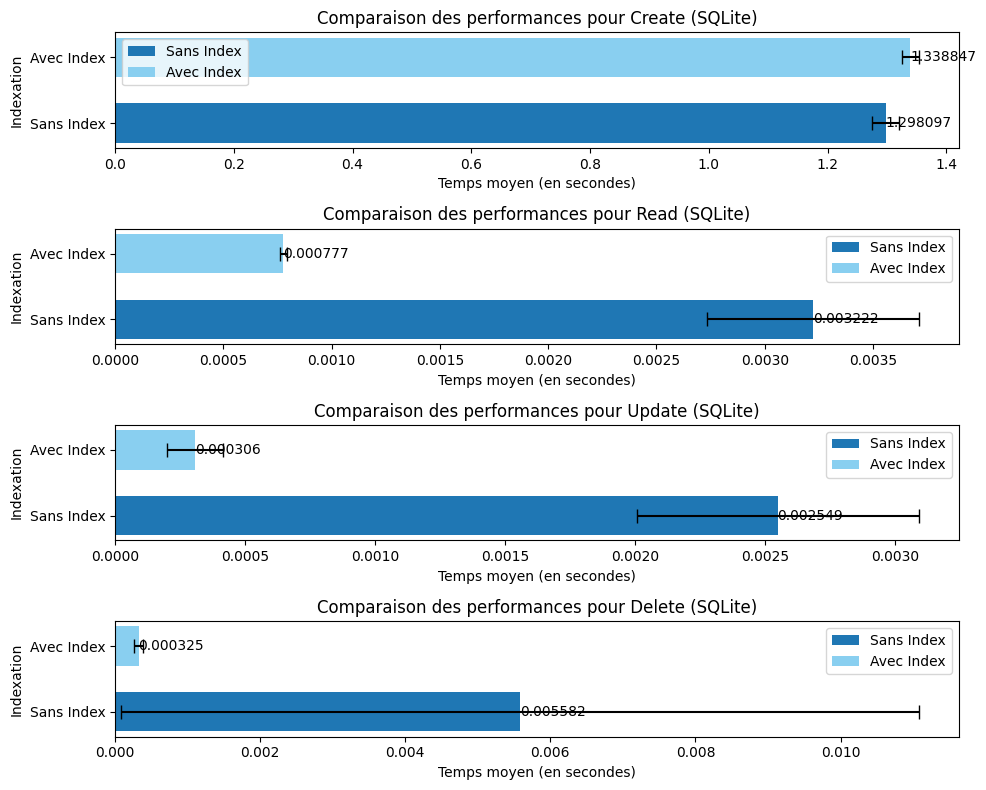

In [47]:
# Actions et temps moyens pour SQLite avec et sans index
actions = ['Create', 'Read', 'Update', 'Delete']

mean_without_index = [create_sqlite_large_mean_time, read_sqlite_large_mean_time, 
                      update_sqlite_large_mean_time, delete_sqlite_large_mean_time]
mean_with_index = [create_sqlite_large_mean_time_index, read_sqlite_large_mean_time_index, 
                   update_sqlite_large_mean_time_index, delete_sqlite_large_mean_time_index]

std_without_index = [create_sqlite_large_std_time, read_sqlite_large_std_time, 
                     update_sqlite_large_std_time, delete_sqlite_large_std_time]
std_with_index = [create_sqlite_large_std_time_index, read_sqlite_large_std_time_index, 
                  update_sqlite_large_std_time_index, delete_sqlite_large_std_time_index]

fig, axes = plt.subplots(4, 1, figsize=(10, 8))  
width = 0.6

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:blue')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#89CFF0')

    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (SQLite)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

plt.tight_layout()
plt.show()


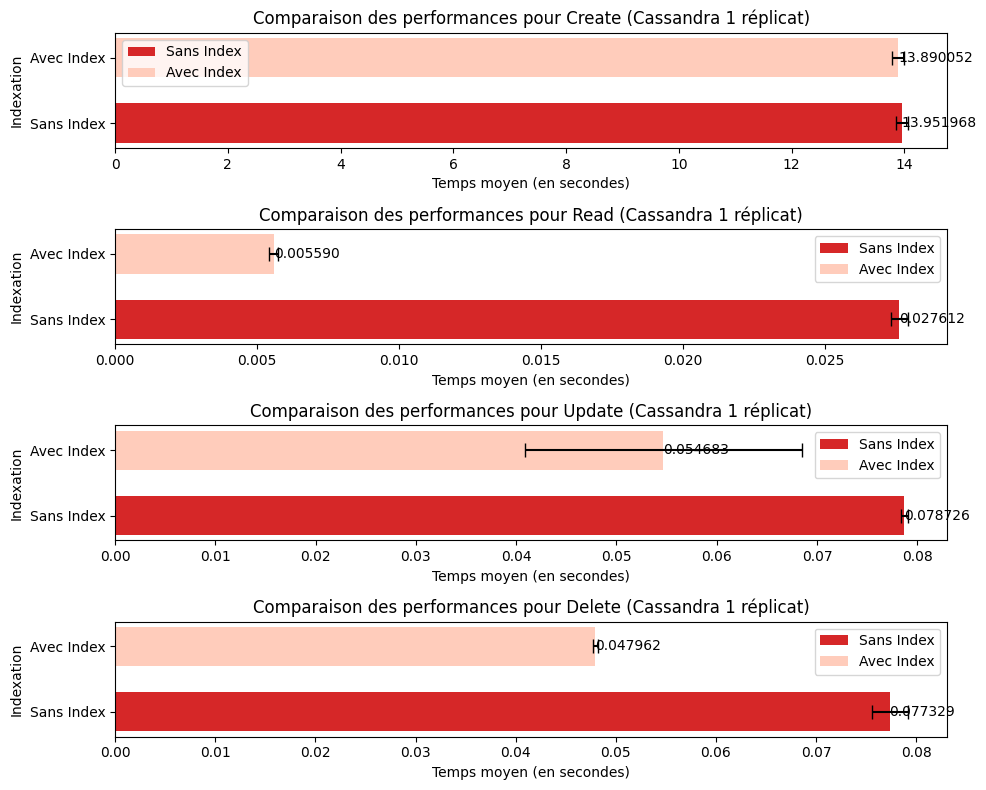

In [48]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_large_mean_time, read_cassandra_large_mean_time, 
                      update_cassandra_large_mean_time, delete_cassandra_large_mean_time]
mean_with_index = [create_cassandra_large_mean_time_index, read_cassandra_large_mean_time_index, 
                   update_cassandra_large_mean_time_index, delete_cassandra_large_mean_time_index]

std_without_index = [create_cassandra_large_std_time, read_cassandra_large_std_time, 
                     update_cassandra_large_std_time, delete_cassandra_large_std_time]
std_with_index = [create_cassandra_large_std_time_index, read_cassandra_large_std_time_index, 
                  update_cassandra_large_std_time_index, delete_cassandra_large_std_time_index]

fig, axes = plt.subplots(4, 1, figsize=(10, 8))  
width = 0.6

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:red')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#FFCCBB')

    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 1 réplicat)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

plt.tight_layout()
plt.show()

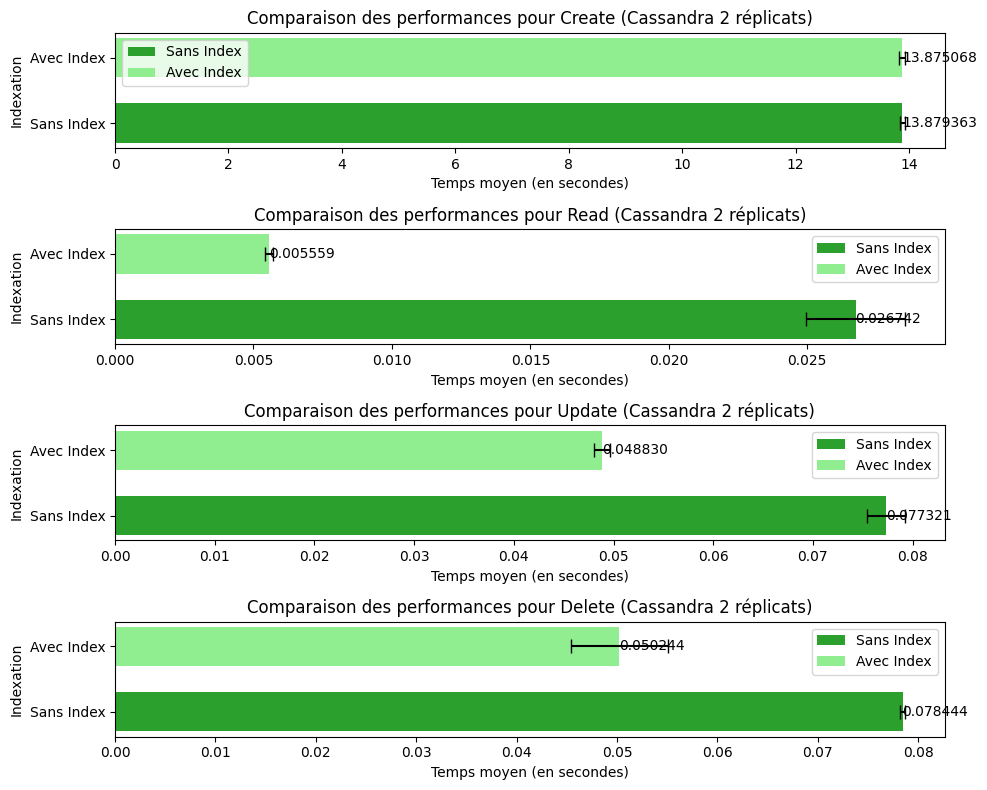

In [49]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_large_mean_time_2, read_cassandra_large_mean_time_2, 
                      update_cassandra_large_mean_time_2, delete_cassandra_large_mean_time_2]
mean_with_index = [create_cassandra_large_mean_time_2_index, read_cassandra_large_mean_time_2_index, 
                   update_cassandra_large_mean_time_2_index, delete_cassandra_large_mean_time_2_index]

std_without_index = [create_cassandra_large_std_time_2, read_cassandra_large_std_time_2, 
                     update_cassandra_large_std_time_2, delete_cassandra_large_std_time_2]
std_with_index = [create_cassandra_large_std_time_2_index, read_cassandra_large_std_time_2_index, 
                  update_cassandra_large_std_time_2_index, delete_cassandra_large_std_time_2_index]

fig, axes = plt.subplots(4, 1, figsize=(10, 8))  
width = 0.6

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:green')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#90EE90')

    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 2 réplicats)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

plt.tight_layout()
plt.show()

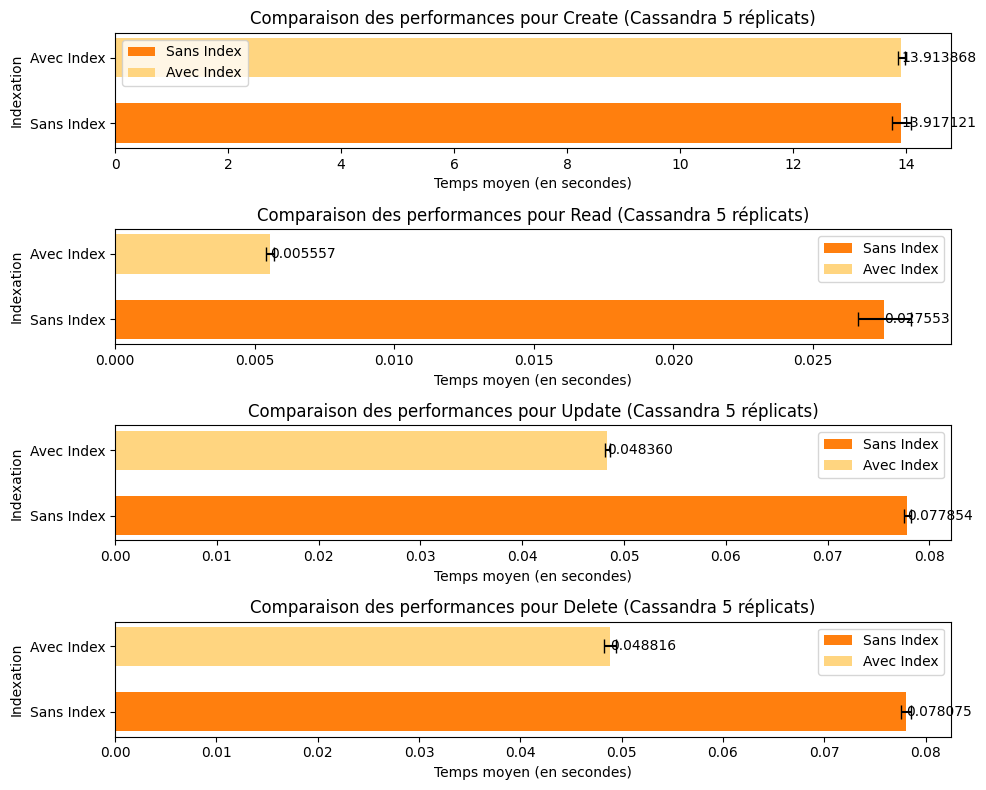

In [50]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_large_mean_time_5, read_cassandra_large_mean_time_5, 
                      update_cassandra_large_mean_time_5, delete_cassandra_large_mean_time_5]
mean_with_index = [create_cassandra_large_mean_time_5_index, read_cassandra_large_mean_time_5_index, 
                   update_cassandra_large_mean_time_5_index, delete_cassandra_large_mean_time_5_index]


std_without_index = [create_cassandra_large_std_time_5, read_cassandra_large_std_time_5, 
                     update_cassandra_large_std_time_5, delete_cassandra_large_std_time_5]
std_with_index = [create_cassandra_large_std_time_5_index, read_cassandra_large_std_time_5_index, 
                  update_cassandra_large_std_time_5_index, delete_cassandra_large_std_time_5_index]

fig, axes = plt.subplots(4, 1, figsize=(10, 8)) 
width = 0.6

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:orange')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#FFD580')

    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 5 réplicats)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

plt.tight_layout()
plt.show()

##### Comparaison de la mémoire avec et sans les index

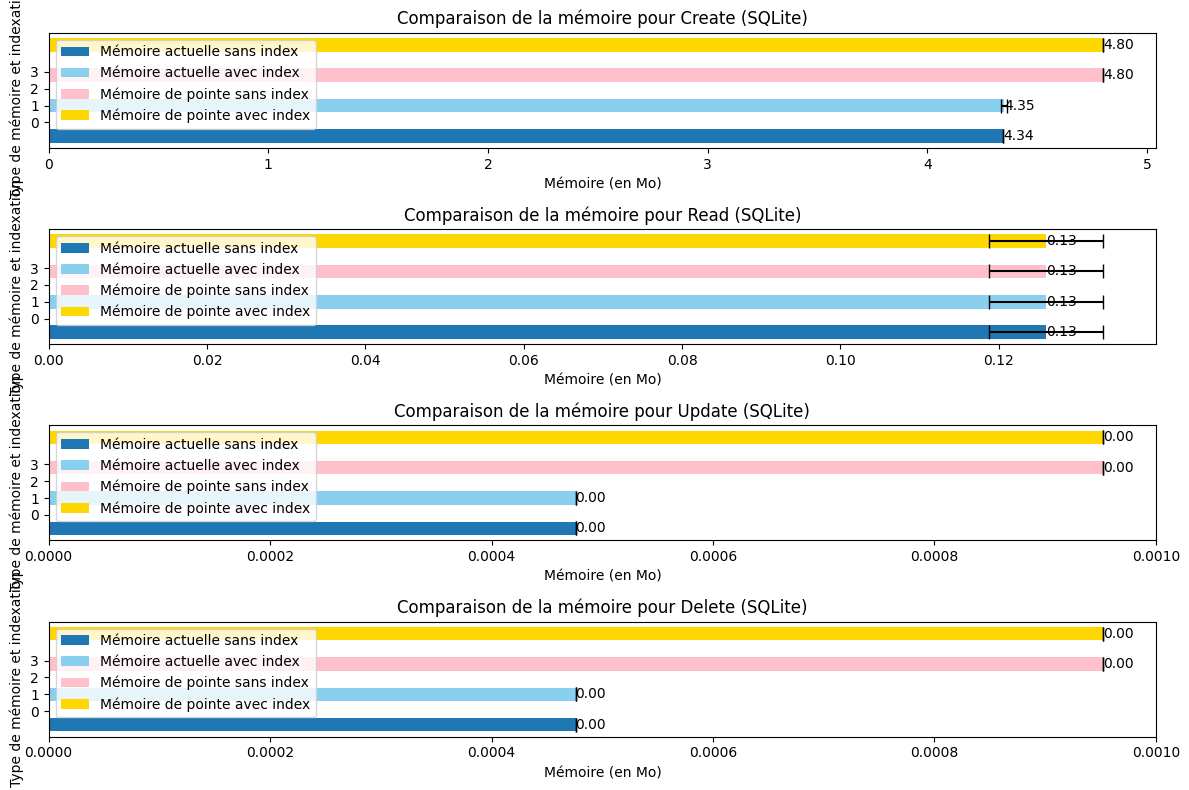

In [51]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_current_without_index = [create_sqlite_large_mean_current_memory, read_sqlite_large_mean_current_memory, 
                              update_sqlite_large_mean_current_memory, delete_sqlite_large_mean_current_memory]
mean_current_with_index = [create_sqlite_large_mean_current_memory_index, read_sqlite_large_mean_current_memory_index, 
                           update_sqlite_large_mean_current_memory_index, delete_sqlite_large_mean_current_memory_index]
std_current_without_index = [create_sqlite_large_std_current_memory, read_sqlite_large_std_current_memory, 
                             update_sqlite_large_std_current_memory, delete_sqlite_large_std_current_memory]
std_current_with_index = [create_sqlite_large_std_current_memory_index, read_sqlite_large_std_current_memory_index, 
                          update_sqlite_large_std_current_memory_index, delete_sqlite_large_std_current_memory_index]

mean_peak_without_index = [create_sqlite_large_mean_peak_memory, read_sqlite_large_mean_peak_memory, 
                           update_sqlite_large_mean_peak_memory, delete_sqlite_large_mean_peak_memory]
mean_peak_with_index = [create_sqlite_large_mean_peak_memory_index, read_sqlite_large_mean_peak_memory_index, 
                        update_sqlite_large_mean_peak_memory_index, delete_sqlite_large_mean_peak_memory_index]
std_peak_without_index = [create_sqlite_large_std_peak_memory, read_sqlite_large_std_peak_memory, 
                          update_sqlite_large_std_peak_memory, delete_sqlite_large_std_peak_memory]
std_peak_with_index = [create_sqlite_large_std_peak_memory_index, read_sqlite_large_std_peak_memory_index, 
                       update_sqlite_large_std_peak_memory_index, delete_sqlite_large_std_peak_memory_index]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))  
width = 0.8  

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:blue')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#89CFF0')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='pink')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='gold')

    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (SQLite)')
    ax.set_yticks(x)
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

plt.tight_layout()
plt.show()


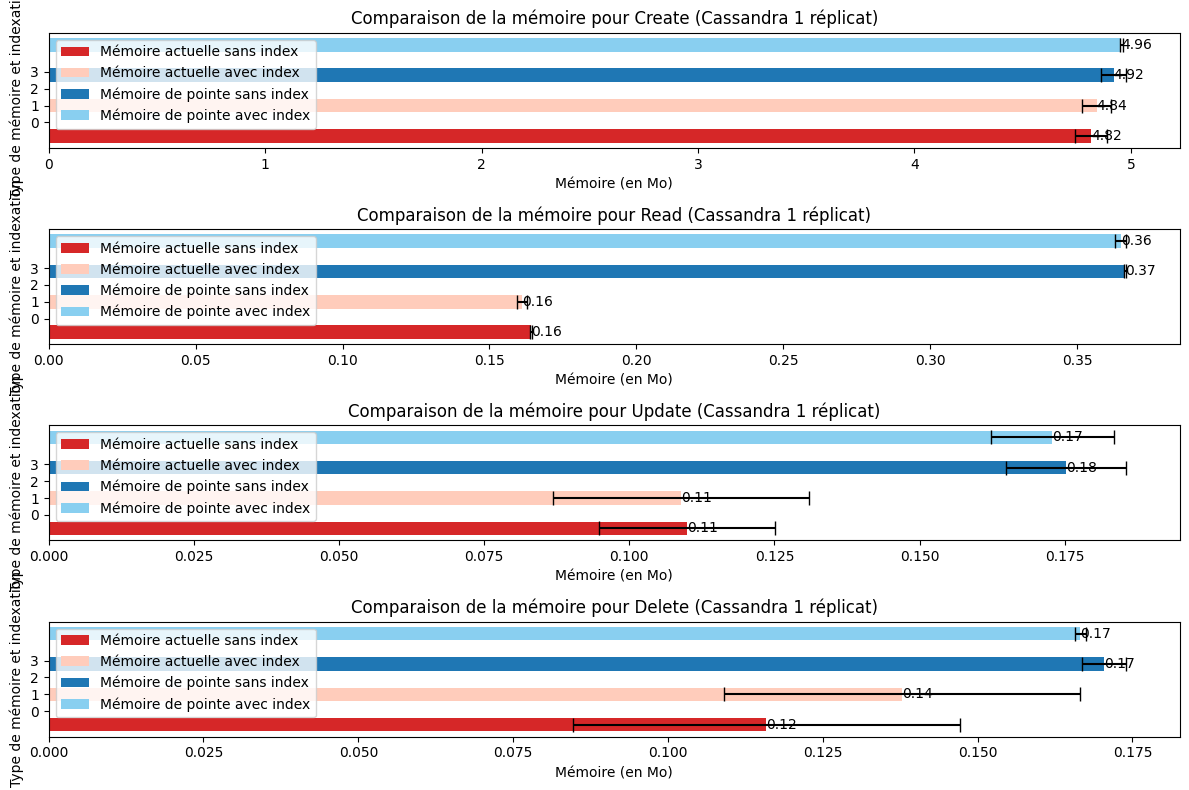

In [52]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_current_without_index = [create_cassandra_large_mean_current_memory, read_cassandra_large_mean_current_memory, 
                              update_cassandra_large_mean_current_memory, delete_cassandra_large_mean_current_memory]
mean_current_with_index = [create_cassandra_large_mean_current_memory_index, read_cassandra_large_mean_current_memory_index, 
                           update_cassandra_large_mean_current_memory_index, delete_cassandra_large_mean_current_memory_index]
std_current_without_index = [create_cassandra_large_std_current_memory, read_cassandra_large_std_current_memory, 
                             update_cassandra_large_std_current_memory, delete_cassandra_large_std_current_memory]
std_current_with_index = [create_cassandra_large_std_current_memory_index, read_cassandra_large_std_current_memory_index, 
                          update_cassandra_large_std_current_memory_index, delete_cassandra_large_std_current_memory_index]

mean_peak_without_index = [create_cassandra_large_mean_peak_memory, read_cassandra_large_mean_peak_memory, 
                           update_cassandra_large_mean_peak_memory, delete_cassandra_large_mean_peak_memory]
mean_peak_with_index = [create_cassandra_large_mean_peak_memory_index, read_cassandra_large_mean_peak_memory_index, 
                        update_cassandra_large_mean_peak_memory_index, delete_cassandra_large_mean_peak_memory_index]
std_peak_without_index = [create_cassandra_large_std_peak_memory, read_cassandra_large_std_peak_memory, 
                          update_cassandra_large_std_peak_memory, delete_cassandra_large_std_peak_memory]
std_peak_with_index = [create_cassandra_large_std_peak_memory_index, read_cassandra_large_std_peak_memory_index, 
                       update_cassandra_large_std_peak_memory_index, delete_cassandra_large_std_peak_memory_index]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))  
width = 0.8 

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:red')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#FFCCBB')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 1 réplicat)')
    ax.set_yticks(x)
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

plt.tight_layout()
plt.show()


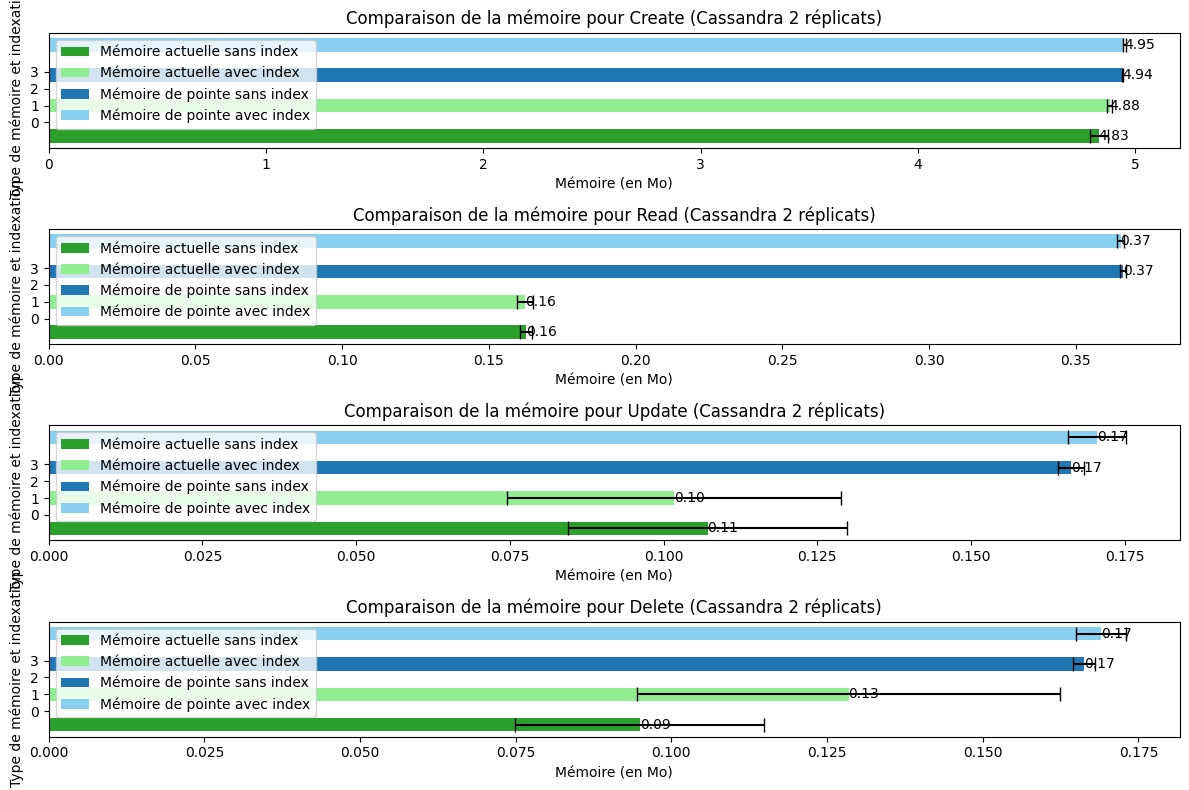

In [53]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_current_without_index = [create_cassandra_large_mean_current_memory_2, read_cassandra_large_mean_current_memory_2, 
                              update_cassandra_large_mean_current_memory_2, delete_cassandra_large_mean_current_memory_2]
mean_current_with_index = [create_cassandra_large_mean_current_memory_2_index, read_cassandra_large_mean_current_memory_2_index, 
                           update_cassandra_large_mean_current_memory_2_index, delete_cassandra_large_mean_current_memory_2_index]
std_current_without_index = [create_cassandra_large_std_current_memory_2, read_cassandra_large_std_current_memory_2, 
                             update_cassandra_large_std_current_memory_2, delete_cassandra_large_std_current_memory_2]
std_current_with_index = [create_cassandra_large_std_current_memory_2_index, read_cassandra_large_std_current_memory_2_index, 
                          update_cassandra_large_std_current_memory_2_index, delete_cassandra_large_std_current_memory_2_index]

mean_peak_without_index = [create_cassandra_large_mean_peak_memory_2, read_cassandra_large_mean_peak_memory_2, 
                           update_cassandra_large_mean_peak_memory_2, delete_cassandra_large_mean_peak_memory_2]
mean_peak_with_index =  [create_cassandra_large_mean_peak_memory_2_index, read_cassandra_large_mean_peak_memory_2_index, 
                           update_cassandra_large_mean_peak_memory_2_index, delete_cassandra_large_mean_peak_memory_2_index]
std_peak_without_index = [create_cassandra_large_std_peak_memory_2, read_cassandra_large_std_peak_memory_2, 
                          update_cassandra_large_std_peak_memory_2, delete_cassandra_large_std_peak_memory_2]
std_peak_with_index = [create_cassandra_large_std_peak_memory_2_index, read_cassandra_large_std_peak_memory_2_index, 
                          update_cassandra_large_std_peak_memory_2_index, delete_cassandra_large_std_peak_memory_2_index]

fig, axes = plt.subplots(4, 1, figsize=(12, 8)) 
width = 0.8

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:green')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#90EE90')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 2 réplicats)')
    ax.set_yticks(x)
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

plt.tight_layout()
plt.show()


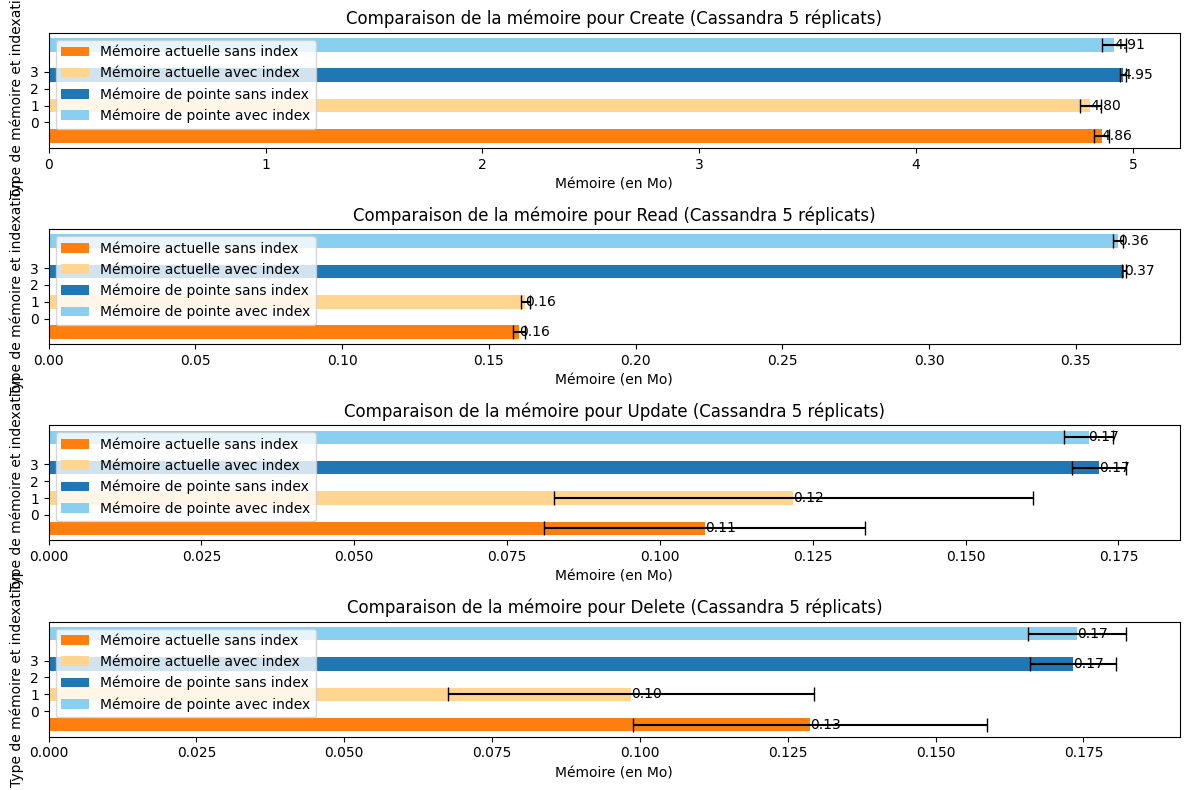

In [54]:
actions = ['Create', 'Read', 'Update', 'Delete']

mean_current_without_index = [create_cassandra_large_mean_current_memory_5, read_cassandra_large_mean_current_memory_5, 
                              update_cassandra_large_mean_current_memory_5, delete_cassandra_large_mean_current_memory_5]
mean_current_with_index = [create_cassandra_large_mean_current_memory_5_index, read_cassandra_large_mean_current_memory_5_index, 
                           update_cassandra_large_mean_current_memory_5_index, delete_cassandra_large_mean_current_memory_5_index]
std_current_without_index = [create_cassandra_large_std_current_memory_5, read_cassandra_large_std_current_memory_5, 
                             update_cassandra_large_std_current_memory_5, delete_cassandra_large_std_current_memory_5]
std_current_with_index = [create_cassandra_large_std_current_memory_5_index, read_cassandra_large_std_current_memory_5_index, 
                          update_cassandra_large_std_current_memory_5_index, delete_cassandra_large_std_current_memory_5_index]

mean_peak_without_index = [create_cassandra_large_mean_peak_memory_5, read_cassandra_large_mean_peak_memory_5, 
                           update_cassandra_large_mean_peak_memory_5, delete_cassandra_large_mean_peak_memory_5]
mean_peak_with_index =  [create_cassandra_large_mean_peak_memory_5_index, read_cassandra_large_mean_peak_memory_5_index, 
                           update_cassandra_large_mean_peak_memory_5_index, delete_cassandra_large_mean_peak_memory_5_index]
std_peak_without_index = [create_cassandra_large_std_peak_memory_5, read_cassandra_large_std_peak_memory_5, 
                          update_cassandra_large_std_peak_memory_5, delete_cassandra_large_std_peak_memory_5]
std_peak_with_index = [create_cassandra_large_std_peak_memory_5_index, read_cassandra_large_std_peak_memory_5_index, 
                          update_cassandra_large_std_peak_memory_5_index, delete_cassandra_large_std_peak_memory_5_index]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))  
width = 0.8 

for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:orange')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#FFD590')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 5 réplicats)')
    ax.set_yticks(x)
    ax.legend()

    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

plt.tight_layout()
plt.show()


Pour SQLite, l'utilisation d'un index n'a pas montré de réelle différence sur l'opération CREATE. En revanche, elle a considérablement amélioré les performances des autres opérations : un gain de vitesse de 4x pour READ, une division par 8 pour UPDATE, et par 9 (ou 10) pour DELETE.

Pour Cassandra, l'impact de l'index est plus nuancé. Aucune différence notable n'a été observée sur CREATE, mais les gains sont significatifs pour les autres opérations : READ est 5 fois plus rapide, tandis que UPDATE et DELETE sont 2 fois plus rapides. Ces constats restent valables pour les configurations avec 2 ou 5 réplicas.

Enfin, en termes de mémoire, l'ajout d'un index ou la modification du nombre de réplicas n'a eu aucun impact, que ce soit pour SQLite ou Cassandra.

# Fin du notebook

In [55]:
# fermer proprement
session.shutdown() # Fermer la connexion Cassandra
cluster.shutdown() # Fermer le cluster Cassandra
conn.close() # Fermer la connexion SQLite

# Conclusion

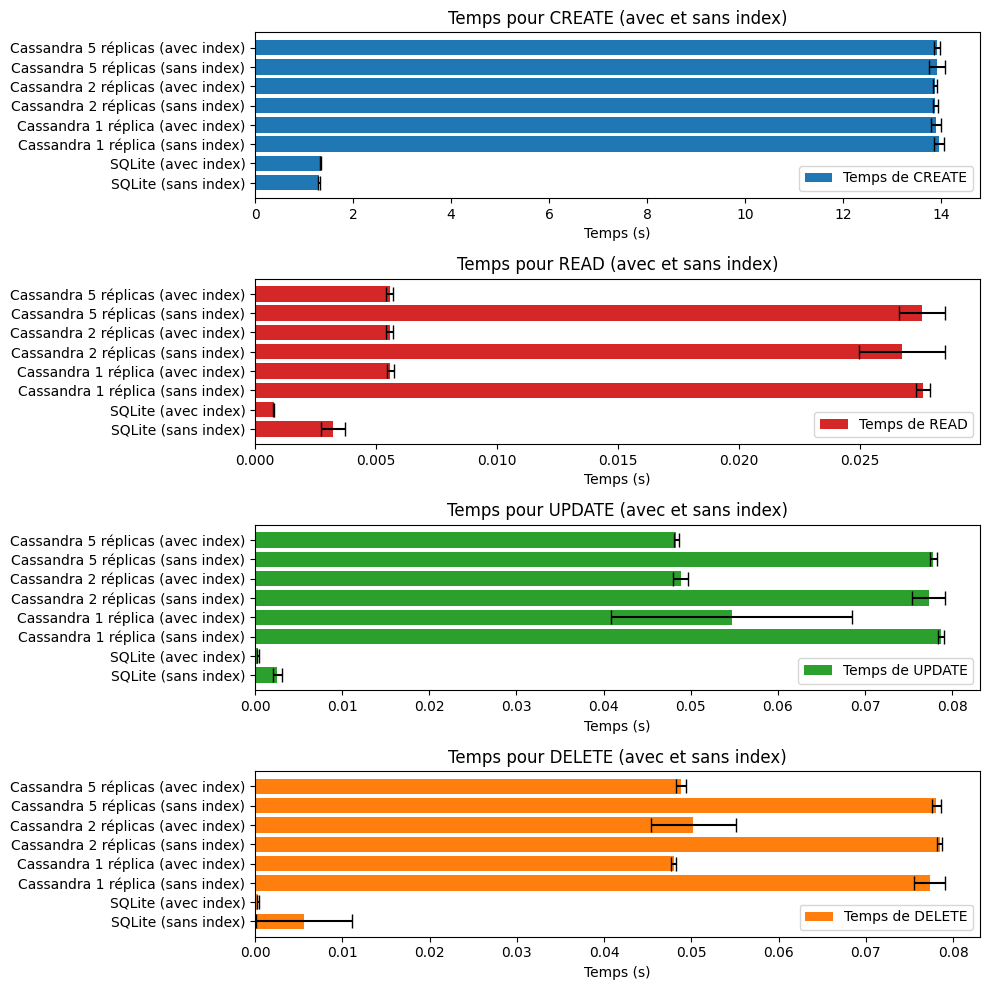

In [56]:
sqlite_times = {
    'CREATE': (create_sqlite_large_mean_time, create_sqlite_large_std_time),
    'READ': (read_sqlite_large_mean_time, read_sqlite_large_std_time),
    'UPDATE': (update_sqlite_large_mean_time, update_sqlite_large_std_time),
    'DELETE': (delete_sqlite_large_mean_time, delete_sqlite_large_std_time)
}

sqlite_times_with_index = {
    'CREATE': (create_sqlite_large_mean_time_index, create_sqlite_large_std_time_index),
    'READ': (read_sqlite_large_mean_time_index, read_sqlite_large_std_time_index),
    'UPDATE': (update_sqlite_large_mean_time_index, update_sqlite_large_std_time_index),
    'DELETE': (delete_sqlite_large_mean_time_index, delete_sqlite_large_std_time_index)
}

cassandra_1_replicas_times = {
    'CREATE': (create_cassandra_large_mean_time, create_cassandra_large_std_time),
    'READ': (read_cassandra_large_mean_time, read_cassandra_large_std_time),
    'UPDATE': (update_cassandra_large_mean_time, update_cassandra_large_std_time),
    'DELETE': (delete_cassandra_large_mean_time, delete_cassandra_large_std_time)
}

cassandra_1_replicas_times_index = {
    'CREATE': (create_cassandra_large_mean_time_index, create_cassandra_large_std_time_index),
    'READ': (read_cassandra_large_mean_time_index, read_cassandra_large_std_time_index),
    'UPDATE': (update_cassandra_large_mean_time_index, update_cassandra_large_std_time_index),
    'DELETE': (delete_cassandra_large_mean_time_index, delete_cassandra_large_std_time_index)
}

cassandra_2_replicas_times = {
    'CREATE': (create_cassandra_large_mean_time_2, create_cassandra_large_std_time_2),
    'READ': (read_cassandra_large_mean_time_2, read_cassandra_large_std_time_2),
    'UPDATE': (update_cassandra_large_mean_time_2, update_cassandra_large_std_time_2),
    'DELETE': (delete_cassandra_large_mean_time_2, delete_cassandra_large_std_time_2)
}

cassandra_2_replicas_times_index = {
    'CREATE': (create_cassandra_large_mean_time_2_index, create_cassandra_large_std_time_2_index),
    'READ': (read_cassandra_large_mean_time_2_index, read_cassandra_large_std_time_2_index),
    'UPDATE': (update_cassandra_large_mean_time_2_index, update_cassandra_large_std_time_2_index),
    'DELETE': (delete_cassandra_large_mean_time_2_index, delete_cassandra_large_std_time_2_index)
}


cassandra_5_replicas_times = {
    'CREATE': (create_cassandra_large_mean_time_5, create_cassandra_large_std_time_5),
    'READ': (read_cassandra_large_mean_time_5, read_cassandra_large_std_time_5),
    'UPDATE': (update_cassandra_large_mean_time_5, update_cassandra_large_std_time_5),
    'DELETE': (delete_cassandra_large_mean_time_5, delete_cassandra_large_std_time_5)
}

cassandra_5_replicas_times_index = {
    'CREATE': (create_cassandra_large_mean_time_5_index, create_cassandra_large_std_time_5_index),
    'READ': (read_cassandra_large_mean_time_5_index, read_cassandra_large_std_time_5_index),
    'UPDATE': (update_cassandra_large_mean_time_5_index, update_cassandra_large_std_time_5_index),
    'DELETE': (delete_cassandra_large_mean_time_5_index, delete_cassandra_large_std_time_5_index)
}


# Définir les couleurs pour chaque base de données et avec/sans index
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']

# Créer les sous-graphes
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# 1. Graphique CREATE - Tous ensemble
axes[0].barh(['SQLite (sans index)', 'SQLite (avec index)', 'Cassandra 1 réplica (sans index)', 
              'Cassandra 1 réplica (avec index)', 'Cassandra 2 réplicas (sans index)', 
              'Cassandra 2 réplicas (avec index)', 'Cassandra 5 réplicas (sans index)', 
              'Cassandra 5 réplicas (avec index)'],
             [sqlite_times['CREATE'][0], sqlite_times_with_index['CREATE'][0],
              cassandra_1_replicas_times['CREATE'][0], cassandra_1_replicas_times_index['CREATE'][0],
              cassandra_2_replicas_times['CREATE'][0], cassandra_2_replicas_times_index['CREATE'][0],
              cassandra_5_replicas_times['CREATE'][0], cassandra_5_replicas_times_index['CREATE'][0]],
             xerr=[sqlite_times['CREATE'][1], sqlite_times_with_index['CREATE'][1],
                   cassandra_1_replicas_times['CREATE'][1], cassandra_1_replicas_times_index['CREATE'][1],
                   cassandra_2_replicas_times['CREATE'][1], cassandra_2_replicas_times_index['CREATE'][1],
                   cassandra_5_replicas_times['CREATE'][1], cassandra_5_replicas_times_index['CREATE'][1]],
             label='Temps de CREATE', color=colors[0], capsize=5)

axes[0].set_title('Temps pour CREATE (avec et sans index)')
axes[0].set_xlabel('Temps (s)')
axes[0].legend()

# 2. Graphique READ - Par base de données
axes[1].barh(['SQLite (sans index)', 'SQLite (avec index)', 'Cassandra 1 réplica (sans index)', 
              'Cassandra 1 réplica (avec index)', 'Cassandra 2 réplicas (sans index)', 
              'Cassandra 2 réplicas (avec index)', 'Cassandra 5 réplicas (sans index)', 
              'Cassandra 5 réplicas (avec index)'],
             [sqlite_times['READ'][0], sqlite_times_with_index['READ'][0],
              cassandra_1_replicas_times['READ'][0], cassandra_1_replicas_times_index['READ'][0],
              cassandra_2_replicas_times['READ'][0], cassandra_2_replicas_times_index['READ'][0],
              cassandra_5_replicas_times['READ'][0], cassandra_5_replicas_times_index['READ'][0]],
             xerr=[sqlite_times['READ'][1], sqlite_times_with_index['READ'][1],
                   cassandra_1_replicas_times['READ'][1], cassandra_1_replicas_times_index['READ'][1],
                   cassandra_2_replicas_times['READ'][1], cassandra_2_replicas_times_index['READ'][1],
                   cassandra_5_replicas_times['READ'][1], cassandra_5_replicas_times_index['READ'][1]],
             label='Temps de READ', color=colors[1], capsize=5)

axes[1].set_title('Temps pour READ (avec et sans index)')
axes[1].set_xlabel('Temps (s)')
axes[1].legend()

# 3. Graphique UPDATE - Par base de données
axes[2].barh(['SQLite (sans index)', 'SQLite (avec index)', 'Cassandra 1 réplica (sans index)', 
              'Cassandra 1 réplica (avec index)', 'Cassandra 2 réplicas (sans index)', 
              'Cassandra 2 réplicas (avec index)', 'Cassandra 5 réplicas (sans index)', 
              'Cassandra 5 réplicas (avec index)'],
             [sqlite_times['UPDATE'][0], sqlite_times_with_index['UPDATE'][0],
              cassandra_1_replicas_times['UPDATE'][0], cassandra_1_replicas_times_index['UPDATE'][0],
              cassandra_2_replicas_times['UPDATE'][0], cassandra_2_replicas_times_index['UPDATE'][0],
              cassandra_5_replicas_times['UPDATE'][0], cassandra_5_replicas_times_index['UPDATE'][0]],
             xerr=[sqlite_times['UPDATE'][1], sqlite_times_with_index['UPDATE'][1],
                   cassandra_1_replicas_times['UPDATE'][1], cassandra_1_replicas_times_index['UPDATE'][1],
                   cassandra_2_replicas_times['UPDATE'][1], cassandra_2_replicas_times_index['UPDATE'][1],
                   cassandra_5_replicas_times['UPDATE'][1], cassandra_5_replicas_times_index['UPDATE'][1]],
             label='Temps de UPDATE', color=colors[2], capsize=5)

axes[2].set_title('Temps pour UPDATE (avec et sans index)')
axes[2].set_xlabel('Temps (s)')
axes[2].legend()

# 4. Graphique DELETE - Par base de données
axes[3].barh(['SQLite (sans index)', 'SQLite (avec index)', 'Cassandra 1 réplica (sans index)', 
              'Cassandra 1 réplica (avec index)', 'Cassandra 2 réplicas (sans index)', 
              'Cassandra 2 réplicas (avec index)', 'Cassandra 5 réplicas (sans index)', 
              'Cassandra 5 réplicas (avec index)'],
             [sqlite_times['DELETE'][0], sqlite_times_with_index['DELETE'][0],
              cassandra_1_replicas_times['DELETE'][0], cassandra_1_replicas_times_index['DELETE'][0],
              cassandra_2_replicas_times['DELETE'][0], cassandra_2_replicas_times_index['DELETE'][0],
              cassandra_5_replicas_times['DELETE'][0], cassandra_5_replicas_times_index['DELETE'][0]],
             xerr=[sqlite_times['DELETE'][1], sqlite_times_with_index['DELETE'][1],
                   cassandra_1_replicas_times['DELETE'][1], cassandra_1_replicas_times_index['DELETE'][1],
                   cassandra_2_replicas_times['DELETE'][1], cassandra_2_replicas_times_index['DELETE'][1],
                   cassandra_5_replicas_times['DELETE'][1], cassandra_5_replicas_times_index['DELETE'][1]],
             label='Temps de DELETE', color=colors[3], capsize=5)

axes[3].set_title('Temps pour DELETE (avec et sans index)')
axes[3].set_xlabel('Temps (s)')
axes[3].legend()

plt.tight_layout()

plt.show()


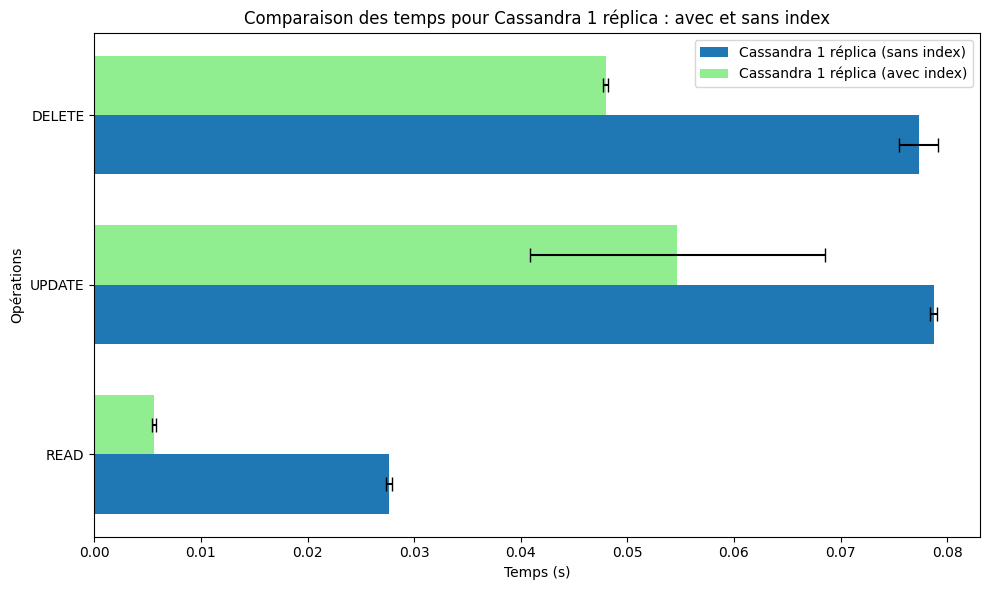

In [57]:
operations = ['READ', 'UPDATE', 'DELETE']

width = 0.35
y = np.arange(len(operations))

fig, ax = plt.subplots(figsize=(10, 6))
# Barres pour Cassandra 1 réplica sans index
ax.barh(y - width/2, [cassandra_1_replicas_times[op][0] for op in operations], 
        width, label='Cassandra 1 réplica (sans index)', color='tab:blue', 
        xerr=[cassandra_1_replicas_times[op][1] for op in operations], capsize=5)

# Barres pour Cassandra 1 réplica avec index
ax.barh(y + width/2, [cassandra_1_replicas_times_index[op][0] for op in operations], 
        width, label='Cassandra 1 réplica (avec index)', color='#90EE90', 
        xerr=[cassandra_1_replicas_times_index[op][1] for op in operations], capsize=5)

ax.set_ylabel('Opérations')
ax.set_xlabel('Temps (s)')
ax.set_title('Comparaison des temps pour Cassandra 1 réplica : avec et sans index')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

plt.tight_layout()
plt.show()


De manière générale, CREATE est beaucoup plus rapide avec SQLite qu'avec Cassandra.

Pour READ, SQLite sans index est légèrement plus rapide que Cassandra avec index, tandis que SQLite avec index est nettement plus performant. À l'inverse, Cassandra sans index est significativement plus lent.

Le nombre de réplicas (1, 2, ou 5) n'a eu aucun impact notable sur les performances pour Cassandra.

Pour UPDATE et DELETE, SQLite est extrêmement rapide, surtout avec un index, où les temps d'exécution sont encore réduits. Cassandra est bien plus lent pour ces deux opérations, mais l'ajout d'un index divise les temps par deux. Cette différence s'explique par le fonctionnement interne de Cassandra : pour effectuer un UPDATE ou un DELETE, il est nécessaire de spécifier la clé primaire complète (partition key + clustering key). Il n'est pas possible de mettre à jour des lignes selon des critères de recherche arbitraires, sauf si ces critères correspondent exactement à la clé primaire. Cela a entrainé des opérations supplémentaires : un SELECT préalable.

Enfin, CREATE reste globalement l'opération la plus longue. 
Cassandra offre des performances compétitives pour READ avec index. 

Sur la mémoire, les métriques current et peak offrent des indications importantes :

- Current correspond à la quantité de mémoire utilisée par l'application au moment de la mesure.
- Peak correspond au maximum de mémoire utilisée durant l'exécution, ce qui reflète les besoins en ressources dans les scénarios les plus intensifs.
Dans nos tests, aucune variation notable n'a été observée pour current 
et peak entre les différentes configurations de réplicas ou 
l'utilisation d'un index, que ce soit pour SQLite ou Cassandra. 
Cependant, nous avons remarqué que pour create, la consommation peak 
de SQLite est similaire à celle de Cassandra, ce qui indique un usage 
mémoire comparable pour cette opération.

### Résultats

Dans cette étude, plusieurs tests ont été réalisés pour comparer 
les performances entre SQLite et Cassandra. Les tests ont été conçus 
de manière simple, avec une mise en place méthodologique d'un benchmark. 
Chaque opération a été répétée cinq fois pour obtenir 
des moyennes et écarts-types (mean et std), en utilisant des requêtes 
cohérentes pour garantir la comparabilité des résultats. Le processus 
comprenait le DROP de toutes les données, suivi d’un CREATE systématique 
(et éventuellement d’un SELECT, UPDATE, ou DELETE selon l’opération testée), ce qui explique les temps longs.

En termes de vitesse, CREATE s'est avéré être l’opération la plus lente pour tous les systèmes testés. En revanche, READ était nettement plus rapide que les autres requêtes dans Cassandra. De manière générale, SQLite s'est montré plus rapide pour toutes les opérations, ce qui s’explique par son fonctionnement local et non distribué, contrairement à Cassandra. Toutefois, cette configuration distribuée n’a pas pu être pleinement testée avec nos ressources matérielles limitées.


Concernant l’ajout de réplicas, aucune différence significative n’a été observée sur les performances. Même constat avec un dataset plus grand (8 800 données et 30 000 entrées) : les différences de temps d’exécution sont restés similaires, bien que l’exécution de ce type de tests sur un dataset encore plus grand aurait été trop exigeante pour notre environnement actuel (le notebook est déjà très long à cause du benchmark).

L’utilisation d’un index a apporté une amélioration nette des 
temps d’exécution, tant pour SQLite que pour Cassandra, réduisant 
considérablement les durées pour READ, UPDATE et DELETE.


### Quelques limitations ont été relevées :

- Le besoin d’utiliser l’option `ALLOW FILTERING` pour Cassandra lors des tests sans clé primaire complète s’est avéré contraignant, imposant des critères d’égalité peu flexibles.

- Les opérations UPDATE et DELETE dans Cassandra nécessitent souvent une étape préalable de SELECT, même lorsqu'un index ou une clé secondaire est utilisé. Cette contrainte, inhérente au fonctionnement de Cassandra, peut introduire un biais dans les comparaisons, car les modifications finales ne sont effectuées que sur la clé primaire complète (partition key + clustering key). Nous avons tenté d’ajouter un champ supplémentaire, comme release year, dans la clé primaire (à la fois comme partition key et comme clustering key). Cependant, cette approche s’est révélée peu concluante :

    - Soit il fallait activer ALLOW FILTERING, ce qui est inefficace et fortement déconseillé dans un contexte de production.
    - Soit il était nécessaire de réaliser un SELECT préalable pour identifier précisément les lignes à mettre à jour ou supprimer, ce qui alourdit les opérations d'UPDATE et de DELETE.

